# **WINES OF THE WORLD**

I was talking to a coworker recently and they casually mentioned how the quarantine life (if you are reading this sometime in the future, yes, I mean the iconic 2020) has made them appreciate good wine more than before. When asked why, they elaborated that previously wine was to be enjoyed with others, you would sit down with an older firend or family, or in a cafe overlooking a busy side walk and sip your wine - and the context would elevate ANY wine really - while now you can only count on Neflix show characters for company, whom are not always really wine people, you know... 
Well, that conversation more interested in digging deeper into the world of wine, and brought me to this data set here! I am going to use my basic knowledge to draw some intersting diagrams to share with the said friend, and also try my luck in creating a recommendation system based on the reviews that each wine has gotten.

Let's do this, shall we?


In [82]:
#importing libraries

import numpy as np 
import folium
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
from collections import Counter
import ast

import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [83]:
!pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.11.0)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [84]:
wine_df = pd.read_csv('/kaggle/input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks





# **1 - Nulls**


First things first, let's take a look at Nulls and missing data in different columns. I noticed a couple of NaNs in the data frame sample above, so I would like to see a diagram of percentage of missing data in each column.




As the figure shows, around 60% of our data miss info in the region_2 column - since all the data has the country and province information, and more than 80% of the data has some info for the wine region, we can safely drop that column. We can then replace the Nulls in region_1 column with an empy string, to avoid any errors when mapping the data with that information.

Then it's notable that around 7% of the data is missing the price tag, which is quite an important feature for wine selection. So I am going to drop rows that miss the price point. We will come back to analyzing the price column again.

Also - in the data frame we have both the name of the taster (commentor) and their twitter handle - but since the twitter handle is not adding any depth to the data, and the missing info in that is higher than missing info in tatser name column, we can also drop that one as well.


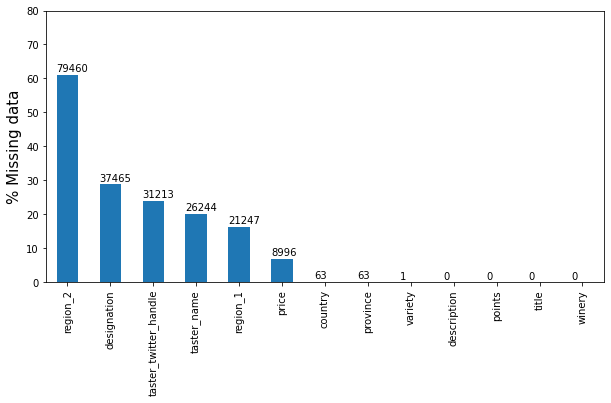

In [85]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_ylabel("% Missing data", fontsize = 15)

nullobj = (wine_df.isnull().sum().to_frame() / len(wine_df) * 100).sort_values(by = 0, ascending = False)
nullobj.plot(kind = 'bar', ax= ax, legend = False, ylim = (0, 80))

for p in ax.patches:
    ax.annotate(str(int(p.get_height() * len(wine_df) // 100)), (p.get_x(), p.get_height() + 1))

Now let's make the suggested changes and draw the figure again, to see if removing the rows that were missing the price data has had any significant effects on the missing data percentages in the rest of the columns.

In [86]:
wine_df = wine_df.drop( ['region_2', 'taster_twitter_handle'], axis = 1)

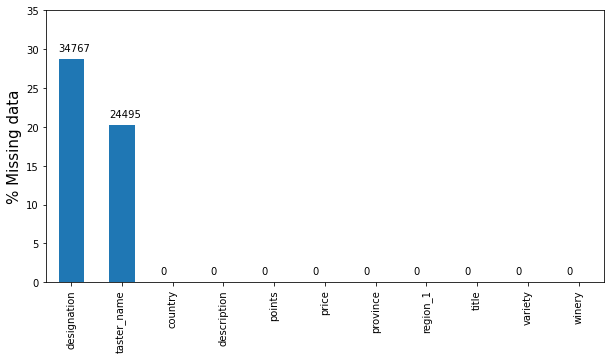

In [87]:
wine_df['region_1'].fillna(value = ' ' , inplace = True )
wine_df = wine_df.dropna( axis = 0, subset = ['price', 'country', 'province', 'variety'])

fig, ax = plt.subplots(figsize = (10, 5))
ax.set_ylabel("% Missing data", fontsize = 15)

nullobj = (wine_df.isnull().sum().to_frame() / len(wine_df) * 100).sort_values(by = 0, ascending = False)
nullobj.plot(kind = 'bar', ax= ax, legend = False, ylim = (0, 35))

for p in ax.patches:
    ax.annotate(str(int(p.get_height() * len(wine_df) // 100)), (p.get_x(), p.get_height() + 1))

The difference is negligible, but the visual representation helps to remind what columns might need extra attention as we go by.
Now since there is about 30% missing data in the column called 'designation', let's take a closer look at it's values and the counts of each, to understand it better. I am going to print the 25 most repeated values in that column:

In [88]:
wine_df['designation'].value_counts().to_frame().head(25)

,designation
Reserve,1977
Estate,1317
Reserva,1219
Estate Grown,618
Riserva,607
Brut,472
Dry,405
Estate Bottled,342
Crianza,338
Vieilles Vignes,272


To my surprise, the values in this column are not quite useful. As an starter, there are multiple values that should have probably been expressed in the same text, for exaple: *Reserve, Reserva, Gran Reserva, Réserve* - or *Rosé of* and *Rosé*. Hence I am not going to use the data in this column for now, unless I find a way to simplify the data in that column.

Next, let's look at the two numerical values assigned to the wines, points and prices, and add a column 'bang for the buck', as a ratio between the two.

In [ ]:
wine_df = wine_df.drop( ['designation'], axis = 1)

In [89]:
wine_df['bang_for_buck'] =  round(wine_df['points'] / wine_df['price'], 2)
wine_df.describe()

,points,price,bang_for_buck
count,120915.000000,120915.000000,120915.000000
mean,88.421726,35.368796,3.840408
std,3.044954,41.031188,2.216757
min,80.000000,4.000000,0.030000
25%,86.000000,17.000000,2.120000
50%,88.000000,25.000000,3.440000
75%,91.000000,42.000000,5.120000
max,100.000000,3300.000000,21.500000


A quick look at the summary of the numerical values reveals that while the points come with an std of 3, and the mean is vey close to the 50% mark, the prices come in a much wider range, with a standard deviation of 41 and a max of 3300. It would make sense to take a closer look at the prices and take out any outliers that might skew any further invesigation.

First let's look at a histogram of the prices - but since we alreay know that 75% of the wines are below $42, we can skew the diagram to only show the bins larger than 100, and stop the diagram at 500 dollars.

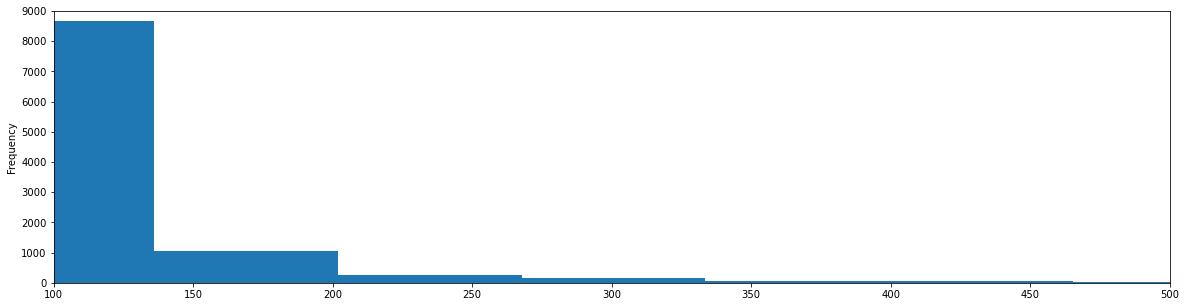

In [90]:
wine_df['price'].plot(kind = 'hist', bins = 50, xlim = (100, 500),ylim = (0,9000), figsize = (20, 5))

The figure above shows that the number of wines above the $200 range are quite limited, but to see the distribution better, we can take a look at the log of prices and their distribution, and a cumulative diagram of frequency of each price point.

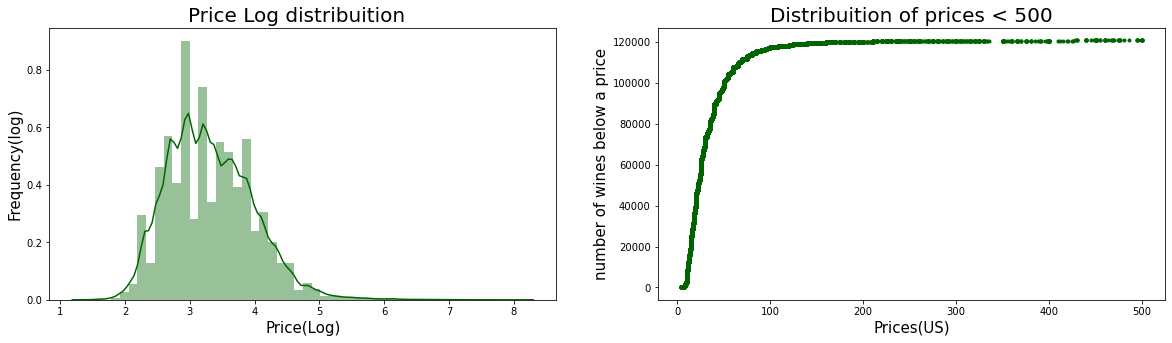

In [91]:
plt.figure(figsize=(20,5))

g1 = plt.subplot(1, 2, 1)
g1 = sns.distplot(np.log(wine_df['price']),color='darkgreen')
g1.set_title("Price Log distribuition  ", fontsize=20)
g1.set_xlabel("Price(Log)", fontsize=15)
g1.set_ylabel("Frequency(log)", fontsize=15)

plt.subplot(1, 2, 2)
plt.scatter(np.sort(wine_df.price.values)[:-100], range(wine_df.shape[0] - 100) , color='darkgreen', marker = '.')
plt.ylabel('number of wines below a price', fontsize=15)
plt.xlabel('Prices(US)', fontsize=15)
plt.title("Distribuition of prices < 500", fontsize=20)


plt.show()

Plot on the left shows that the price log distribution is not too far from the normal distribution, and the plot on the right shows that at some point between the prices of 100 and 200, the curves flattens which means there are not too many more data points after that. I think we can safely drop the wines with prices above 150, or alternatively change all those prices to 200 to represent the 'pricy' bucket.
For now I will remove them.

In [245]:
wine_df = wine_df[wine_df['price'] < 150]

Text(0, 0.5, 'frequency')

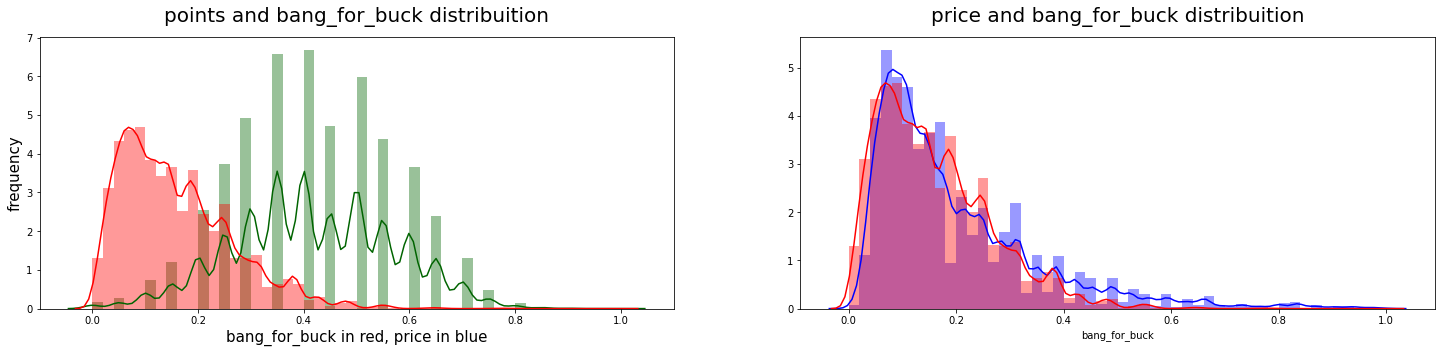

In [93]:
scaler = MinMaxScaler()
scaled = wine_df[['bang_for_buck', 'price', 'points']]

scaled = scaler.fit_transform(scaled)
scaled = pd.DataFrame({'bang_for_buck': scaled[:, 0], 'price': scaled[:, 1], 'points': scaled[:, 2]})

plt.figure(figsize=(25,5))

g1 = plt.subplot(1, 2, 1)
g1 = sns.distplot((scaled['points']),color='darkgreen')
g1 = sns.distplot((scaled['bang_for_buck']),color='red')
g1.set_title("points and bang_for_buck distribuition", fontsize=20, pad = 15)
g1.set_xlabel("bang_for_buck in red, points in green", fontsize=15)
g1.set_ylabel("frequency", fontsize=15)

g2 = plt.subplot(1, 2, 2)
g2 = sns.distplot((scaled['price']),color='blue')
g2 = sns.distplot((scaled['bang_for_buck']),color='red')
g2.set_title("price and bang_for_buck distribuition", fontsize=20, pad = 15)
g1.set_xlabel("bang_for_buck in red, price in blue", fontsize=15)
g1.set_ylabel("frequency", fontsize=15)



It is quite interesting that the two data points, 'price' and 'points per dollar' line up so closely on each other, while the distribution of the points is quite different from both items. To convert the data points to more useful items, we can bin the 'bang_for_buck' column into a few bands to see if we can use at as some sort of a ranking system between the wines. There is no right or wrong anser for the number of the bins, but I will be testing numbers between 4 to 10 to see which one has a more compelling look on it.

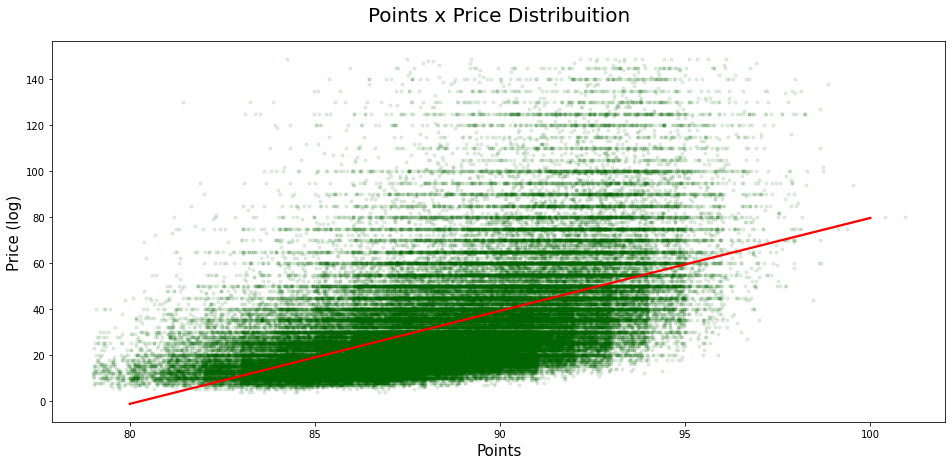

In [266]:
plt.figure(figsize=(16,7))

g = sns.regplot(x='points', y='price', data=wine_df , line_kws={'color':'red'}, marker = '.', x_jitter=True, fit_reg=True, color='darkgreen', scatter_kws={'alpha':0.1})
g.set_title("Points x Price Distribuition", fontsize=20, pad = 20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

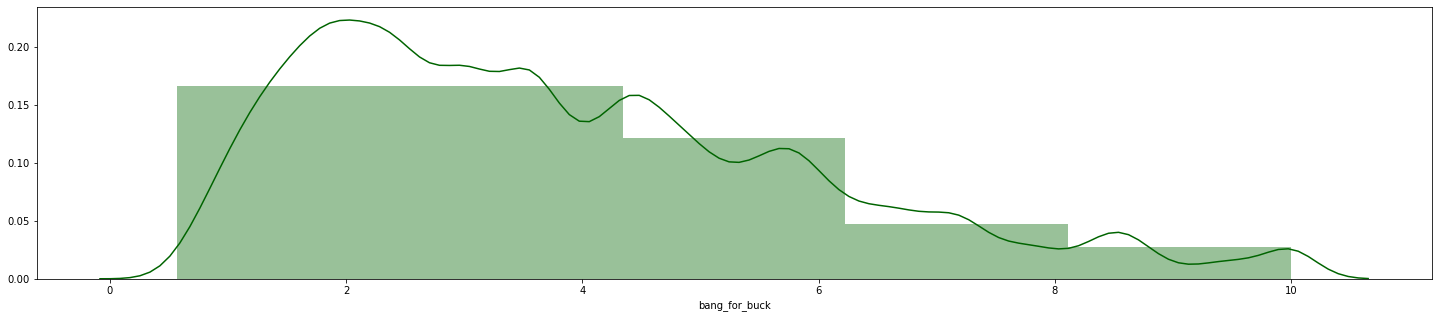

In [187]:
bb_bins = 5

plt.figure(figsize=(25,5))
wine_df['bang_for_buck'] = wine_df['bang_for_buck'].apply(lambda x: min(x, 10))
g1 = sns.distplot((wine_df['bang_for_buck']),color='darkgreen', bins = bb_bins)

In [188]:
wine_df['bang_for_buck_bin'] = 0
wine_df['bang_for_buck_bin'] = pd.cut(wine_df['bang_for_buck'], bins = bb_bins, labels = range(bb_bins))

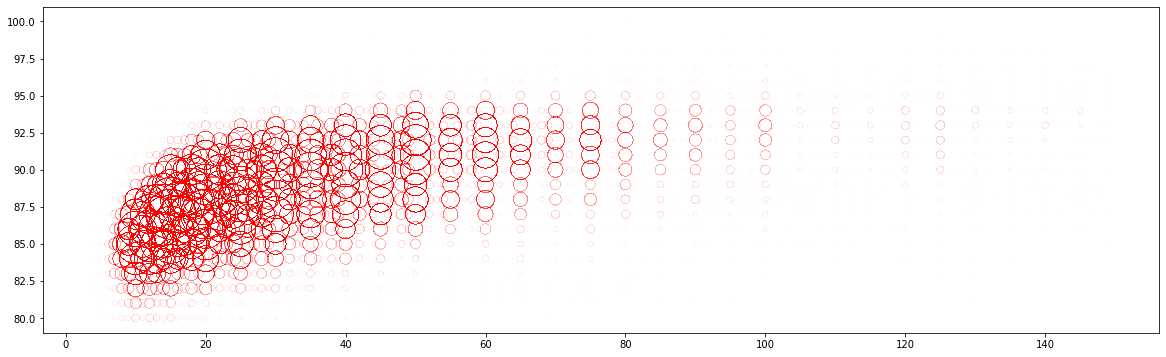

In [250]:
combos = list(zip(wine_df['price'],wine_df['points']))
weight_counter = Counter(combos)
weights = [weight_counter[(wine_df.iloc[i]['price'], wine_df.iloc[i]['points'])] for i in range(len(wine_df))]

#cdict = {0: 'mistyrose', 1:'lightpink'  , 2: 'salmon', 3: 'lightcoral', 4: 'brown', 5: 'blue'}


weights_2 = [item ** 1.1 for item in weights]
plt.figure(figsize=(20,6))
plt.scatter(wine_df['price'], wine_df['points'], s = weights_2, facecolors='none', edgecolors= 'red', alpha = 0.002 )
plt.show()

Here is a very interesting view of prices vs. points of our wines - the size and color of the circles above, show the frequency of a specific (price, point) pair in our set, and so far it looks like we have quite a density in our set for wines between 15 to 40 dollrs, with points ranging from 83 to 92.

I am going to try to draw the same diagram with sns since that might be easier to read:

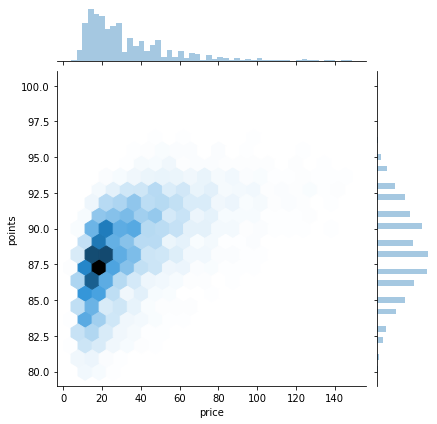

In [270]:
g = sns.jointplot(data = wine_df, x= 'price', y = 'points', kind="hex", joint_kws=dict(gridsize=20))

As I had imagined, the sns plot is in fact easier to read. As a wine enthusiast I find this quite fascinating, as it shows that with wines above 25 dollars, it is highly likely that you will get a wine with any score above 87.5, but with wines in the price range below that you are more likely to find a wine that would fall well below 90 points.






# wine varieties


time to take a look at types of wine in this data set! 
We will look at the number of each type in our set, their average price, average points, and try to understand the wines from that lense as well.

In [248]:
var_counts = (wine_df['variety'].value_counts()) / len(wine_df) * 100

fig, ax = plt.subplots(figsize=(20,5))
ax = var_counts.iloc[:30].plot(kind="bar")
ax.set_ylabel('percentage of all wines', fontsize=12)

Pinot Noir                  10.547114
Chardonnay                   9.177446
Cabernet Sauvignon           7.600988
Red Blend                    7.007409
Bordeaux-style Red Blend     4.326678
Riesling                     4.109004
Sauvignon Blanc              4.001842
Syrah                        3.395705
Rosé                         2.728452
Merlot                       2.543430
Zinfandel                    2.267152
Malbec                       2.154130
Sangiovese                   1.949851
Nebbiolo                     1.886224
Portuguese Red               1.829294
White Blend                  1.811713
Sparkling Blend              1.690318
Tempranillo                  1.475156
Rhône-style Red Blend        1.169576
Pinot Gris                   1.162041
Cabernet Franc               1.090041
Grüner Veltliner             0.957763
Champagne Blend              0.940182
Pinot Grigio                 0.838880
Portuguese White             0.825485
Viognier                     0.824647
Gewürztramin

In [246]:
var_counts.iloc[:30].sum()

81.1252040688183

# Location, location, location

Now that we have looked at points and prices, let's take a look at the origin of the wines. Here is a function that can look up latittude and longtitude numbers for any location - but since the data is larger than what my computer can take, I will be only using it on the top most expensive wines, and the top most appreciated wines (point wise)

In [96]:
from geopy.geocoders import Nominatim

def latlong(region):
    geoloc = Nominatim(user_agent="wine_app")
    loc = geoloc.geocode(region)
    if not loc:
        no_latlong.append(region)
        country = region.split(' ')
        loc = geoloc.geocode(country[0])
    if loc:
        return [round(2*loc.latitude) / 2, round(2*loc.longitude)/2]
    return 

In [97]:
wine_df['province'].replace(['Other'] ,' ', inplace = True)
wine_df['province'].replace(['Northern Spain'] ,' ', inplace = True)
wine_df['province'].replace(['Sicily & Sardinia'] ,'Sicily', inplace = True)
wine_df['province'].replace(['Northeastern Italy'] ,'Turin', inplace = True)
wine_df['province'].replace(['Vino de la Tierra de Castilla y León'] ,'Castilla y León', inplace = True)


In [272]:
wine_df['province'].value_counts()[:10]

Tuscany                 4985
Napa Valley             4283
Columbia Valley (WA)    4108
Bordeaux                3886
Mendoza Province        3208
Russian River Valley    3090
Piedmont                3009
Burgundy                2850
New York                2676
California              2628
Name: province, dtype: int64

In [98]:
def californication(row):
    if (row['province'] in ['California', 'Washington', 'Oregon', ' ']) and len(row['region_1']) > 2 :
        return row['region_1']
    else:
        return row['province']

In [99]:
wine_df['province'] = wine_df.apply( lambda row: californication(row), axis = 1)
wine_df['address'] = wine_df.apply( lambda x : str(x['country']) + ' ' + str(x['province']), axis = 1)

In [100]:
latlong_dict = {'Portugal Douro': '[41.0, -7.5]',
 'US Willamette Valley': '[45.5, -122.5]',
 'US Michigan': '[43.5, -84.5]',
 'Spain Navarra': '[42.5, -2.0]',
 'Italy Sicily': '[37.5, 14.0]',
 'France Alsace': '[48.0, 7.5]',
 'Germany Rheinhessen': '[50.0, 8.5]',
 'US Napa Valley': '[34.0, -84.0]',
 'US Alexander Valley': '[38.5, -123.0]',
 'US Central Coast': '[-33.5, 151.5]',
 'Germany Mosel': '[50.5, 7.5]',
 'Argentina Cafayate': '[-26.0, -66.0]',
 'Argentina Mendoza Province': '[-38.0, -68.0]',
 'Spain Ribera del Duero': '[41.5, -3.5]',
 'US Virginia': '[37.0, -78.5]',
 'US Oregon': '[44.0, -120.5]',
 'US Paso Robles': '[35.5, -120.5]',
 'US Sonoma Coast': '[39.0, -123.0]',
 'US Clarksburg': '[39.5, -80.5]',
 'US Dry Creek Valley': '[49.0, -125.0]',
 'US Sonoma Valley': '[38.0, -86.0]',
 'US McMinnville': '[45.0, -123.0]',
 'Chile Colchagua Valley': '[-34.5, -71.5]',
 'Italy Southern Italy': '[42.5, 12.5]',
 'France Beaujolais': '[45.5, 6.0]',
 'Chile Maule Valley': '[-36.0, -72.0]',
 'France Bordeaux': '[45.0, -0.5]',
 'US North Coast': '[41.5, -81.5]',
 'Chile Maipo Valley': '[-33.5, -70.5]',
 'US Columbia Valley (WA)': '[47.5, -122.5]',
 'France Champagne': '[46.0, -1.0]',
 'US Santa Ynez Valley': '[34.5, -120.0]',
 'France Burgundy': '[47.5, 4.0]',
 'US California': '[36.5, -119.0]',
 'US Howell Mountain': '[38.5, -122.5]',
 'Australia South Australia': '[-30.5, 135.5]',
 'Chile Rapel Valley': '[-34.0, -71.5]',
 'Spain Galicia': '[42.5, -8.0]',
 'France France Other': '[49.0, 2.5]',
 'US Ancient Lakes': '[43.0, -115.0]',
 'US Knights Valley': '[28.0, -82.0]',
 'Italy Tuscany': '[43.5, 11.0]',
 'Austria Burgenland': '[47.5, 16.5]',
 'US New York': '[40.5, -74.0]',
 'Chile Leyda Valley': '[-33.5, -71.5]',
 'US Santa Clara Valley': '[39.0, -84.5]',
 'Italy Piedmont': '[45.0, 8.5]',
 'US Rockpile': '[30.5, -104.0]',
 'South Africa Stellenbosch': '[-34.0, 19.0]',
 'South Africa Simonsberg-Stellenbosch': '[36.5, 127.5]',
 'US Santa Lucia Highlands': '[40.0, -100.5]',
 'US Spring Mountain District': '[54.0, -122.0]',
 'US Monterey': '[36.0, -121.5]',
 'Portugal Alentejano': '[39.0, -7.5]',
 'US Carmel Valley': '[36.5, -121.5]',
 'Spain Central Spain': '[39.5, -5.0]',
 'US Santa Cruz Mountains': '[37.0, -122.0]',
 'France Southwest France': '[46.5, 2.0]',
 'US Edna Valley': '[29.0, -96.5]',
 'Chile Aconcagua Valley': '[-32.5, -70.5]',
 'Chile Loncomilla Valley': '[-28.5, -71.0]',
 'New Zealand Marlborough': '[-41.5, 174.0]',
 'Italy Turin': '[45.0, 7.5]',
 'US Arroyo Seco': '[36.0, -106.0]',
 'Argentina Salta': '[-25.0, -64.5]',
 'US Anderson Valley': '[39.0, -123.5]',
 'Italy Veneto': '[45.5, 12.0]',
 'South Africa Western Cape': '[-33.5, 20.5]',
 'US Nevada County': '[39.5, -121.0]',
 'Israel Judean Hills': '[31.5, 35.0]',
 'Portugal Alentejo': '[38.0, -8.0]',
 'France Rhône Valley': '[46.0, 5.5]',
 'Spain Rueda': '[41.5, -5.0]',
 'Israel Galilee': '[33.0, 35.5]',
 'Portugal Beira Atlantico': '[40.0, -8.0]',
 'Hungary Tokaj': '[48.0, 21.5]',
 'US Diamond Mountain District': '[15.0, 121.0]',
 'US Mendocino': '[39.5, -123.5]',
 'Argentina San Juan': '[-30.5, -69.0]',
 'US Amador County': '[38.5, -120.5]',
 'US Cole Ranch': '[32.0, -102.5]',
 'US Santa Maria Valley': '[35.0, -120.5]',
 'Austria Leithaberg': '[48.0, 16.5]',
 'Greece Santorini': '[36.5, 25.5]',
 'Austria Kremstal': '[48.0, 14.0]',
 'US Dundee Hills': '[39.0, -94.5]',
 'Spain Catalonia': '[42.0, 1.5]',
 'Romania Recas': '[46.0, 21.5]',
 "New Zealand Hawke's Bay": '[-39.5, 177.0]',
 'Chile Curicó Valley': '[-35.0, -71.0]',
 'Chile Limarí Valley': '[-30.5, -71.5]',
 'Chile Colchagua Costa': '[-34.5, -71.0]',
 'France Languedoc-Roussillon': '[43.5, 3.5]',
 'France Provence': '[43.5, 5.5]',
 'Australia Victoria': '[-36.5, 144.5]',
 'Germany Rheingau': '[50.0, 8.0]',
 'Mexico Valle de Guadalupe': '[21.0, -102.5]',
 'US Rutherford': '[41.0, -74.0]',
 'Chile Central Valley': '[-32.0, -71.5]',
 'Chile Lontué Valley': '[-35.0, -71.5]',
 'US Walla Walla Valley (WA)': '[46.0, -118.5]',
 'Austria Weinviertel': '[48.5, 16.5]',
 'Spain Rioja': '[42.5, -2.5]',
 'US Wahluke Slope': '[46.5, -119.5]',
 'US Snipes Mountain': '[46.5, -120.0]',
 'Spain Bierzo': '[42.5, -6.5]',
 'Austria Niederösterreich': '[48.5, 16.0]',
 'France Loire Valley': '[46.5, 4.5]',
 'Italy Lombardy': '[45.5, 10.0]',
 'Canada Ontario': '[50.0, -86.0]',
 'US Carneros': '[33.0, -111.5]',
 'US Ribbon Ridge': '[29.5, -98.5]',
 'US Red Mountain': '[37.0, -105.0]',
 'US Sta. Rita Hills': '[7.0, 125.5]',
 'US El Dorado': '[33.0, -92.5]',
 'US Suisun Valley': '[38.0, -122.0]',
 'US Lodi': '[38.0, -121.5]',
 'Austria Österreichischer Sekt': '[47.0, 13.0]',
 'US Yakima Valley': '[46.5, -120.5]',
 'US Chiles Valley': '[38.5, -95.0]',
 'US Chehalem Mountains': '[45.5, -123.0]',
 'US Umpqua Valley': '[43.5, -123.5]',
 'US Green Valley': '[40.5, -89.5]',
 'US Sierra Foothills': '[33.5, -112.0]',
 'US Yolo County': '[38.5, -122.0]',
 'US Washington': '[39.0, -77.0]',
 'US Columbia Gorge (WA)': '[45.5, -121.0]',
 'Austria Steiermark': '[47.5, 15.0]',
 'Austria Südsteiermark': '[47.0, 15.5]',
 'Greece Crete': '[35.5, 24.5]',
 'US Rogue Valley': '[44.0, -91.0]',
 'Portugal Vinho Verde': '[41.0, -8.0]',
 'US Idaho': '[43.5, -114.0]',
 'Portugal Tejo': '[38.5, -9.0]',
 'Australia Western Australia': '[-25.0, 121.0]',
 'US Mokelumne River': '[38.0, -121.0]',
 'US Los Carneros': '[40.5, -3.5]',
 'Spain Levante': '[38.5, -1.0]',
 'US Livermore Valley': '[37.5, -122.0]',
 'New Zealand Martinborough': '[-41.0, 175.5]',
 'New Zealand Central Otago': '[-45.0, 169.5]',
 'US Texas': '[32.0, -99.5]',
 'Australia Australia Other': '[-35.5, 149.0]',
 'US Temecula Valley': '[33.5, -117.0]',
 'Australia Tasmania': '[-42.0, 146.5]',
 'Spain Cariñena': '[41.5, -1.0]',
 'Germany Franken': '[51.0, 12.5]',
 'Germany Ahr': '[50.5, 7.0]',
 'US Ballard Canyon': '[33.5, -118.0]',
 'Germany Nahe': '[54.0, 10.0]',
 'nan nan': '[46.5, 11.0]',
 'US Shenandoah Valley (CA)': '[39.5, -75.5]',
 'Romania Dealu Mare': '[46.5, 23.0]',
 'Spain Valdeorras': '[42.5, -7.0]',
 'Spain Bizkaiko Txakolina': '[43.5, -2.0]',
 'South Africa Darling': '[-33.5, 18.5]',
 'Portugal Port': '[37.0, -8.0]',
 'Austria Südoststeiermark': '[47.0, 16.0]',
 'Greece Corinth': '[38.0, 23.0]',
 'Greece Halkidiki': '[40.5, 23.5]',
 'US Napa-Sonoma': '[38.0, -122.5]',
 'Turkey Thrace': '[41.0, 27.5]',
 'Germany Pfalz': '[52.0, 10.5]',
 'South Africa Robertson': '[-34.0, 20.0]',
 'US Fair Play': '[37.5, -93.5]',
 'Spain Andalucia': '[37.5, -4.5]',
 'New Zealand Awatere Valley': '[-37.5, 178.5]',
 'Austria Wachau': '[48.5, 15.5]',
 'US Pennsylvania': '[41.0, -77.5]',
 'US Southern Oregon': '[42.0, -122.5]',
 'Portugal Dão': '[40.5, -8.5]',
 'US Coombsville': '[33.0, -97.0]',
 'Chile Rio Claro': '[-35.5, -71.5]',
 'Hungary Villány': '[46.0, 18.5]',
 'Chile Cachapoal Valley': '[-34.0, -70.5]',
 'Romania Jidvei': '[46.0, 24.0]',
 'US Oakville': '[41.0, -91.0]',
 'US America': '[33.5, -87.5]',
 'Argentina Patagonia': '[-45.0, -71.0]',
 'US Applegate Valley': '[39.0, -121.0]',
 'Austria Traisental': '[48.0, 15.5]',
 'Portugal Bairrada': '[40.0, -8.5]',
 'Israel Negev Hills': '[31.0, 34.5]',
 'US San Benito County': '[36.5, -121.0]',
 'Spain Calatayud': '[41.5, -1.5]',
 'US New Jersey': '[40.0, -74.5]',
 'US Santa Barbara': '[34.5, -119.5]',
 'Israel Upper Galilee': '[33.0, 35.0]',
 'US Columbia Valley (OR)': '[49.5, -123.0]',
 'Greece Epanomi': '[40.5, 23.0]',
 'Greece Nemea': '[38.0, 22.5]',
 'Greece Peloponnese': '[37.5, 22.0]',
 'US Red Hills Lake County': '[31.5, -94.0]',
 'Czech Republic Moravia': '[49.5, 18.0]',
 'Spain Toro': '[41.5, -5.5]',
 'Slovenia Slovenia': '[46.0, 14.5]',
 'US South Coast': '[32.5, -117.5]',
 'US Potter Valley': '[39.5, -123.0]',
 'Portugal Terras do Dão': '[38.5, -28.0]',
 'Portugal Beira Interior': '[40.5, -7.5]',
 'US Chalk Hill': '[30.5, -85.5]',
 'Romania Panciu': '[46.0, 27.0]',
 'US Cucamonga Valley': '[40.0, 9.5]',
 'Chile Bío Bío Valley': '[-37.5, -72.5]',
 'Romania Romania': '[46.0, 24.5]',
 'US Fiddletown': '[38.5, -121.0]',
 'Portugal Minho': '[42.0, -8.5]',
 'US Missouri': '[39.0, -92.5]',
 'US New Mexico': '[34.5, -106.0]',
 'US Nevada': '[39.5, -117.0]',
 'Portugal Bucelas': '[39.0, -9.0]',
 'Argentina Alto Valle del Río Negro': '[-35.0, -65.0]',
 'Spain Empordà': '[42.0, 3.0]',
 'Austria Carnuntum': '[48.0, 17.0]',
 'Portugal Estremadura': '[39.5, -9.0]',
 'New Zealand Canterbury': '[-43.5, 172.0]',
 'Spain Campo de Borja': '[42.0, -1.5]',
 'Greece Drama': '[41.0, 24.0]',
 'US Adelaida District': '[-35.0, 138.5]',
 'Luxembourg Moselle Luxembourgeoise': '[50.0, 6.0]',
 'South Africa Walker Bay': '[-34.5, 19.5]',
 'Germany Württemberg': '[49.0, 9.5]',
 'Germany Baden': '[53.0, 9.0]',
 'Greece Pangeon': '[39.0, 22.0]',
 'Chile Elqui Valley': '[-23.5, -70.5]',
 'New Zealand Wairau Valley': '[-41.5, 173.5]',
 'Argentina Neuquén': '[-38.5, -70.0]',
 'Croatia Istria': '[45.0, 14.0]',
 'Croatia Peljesac': '[43.0, 17.5]',
 'US Lake Chelan': '[48.0, -120.5]',
 'Georgia Kakheti': '[41.5, 45.5]',
 'Uruguay Canelones': '[-34.5, -56.0]',
 'England England': '[51.0, 14.0]',
 'US Rattlesnake Hills': '[45.0, -84.5]',
 'South Africa Paarl': '[-33.5, 19.0]',
 'Argentina Río Negro Valley': '[-40.5, -67.5]',
 'Greece Mantinia': '[37.0, 22.0]',
 'Lebanon Lebanon': '[34.0, 36.0]',
 'Germany Mosel-Saar-Ruwer': '[51.0, 10.5]',
 'US Colorado': '[38.5, -105.5]',
 'Serbia Pocerina': '[44.0, 21.0]',
 'Canada British Columbia': '[55.0, -125.0]',
 'New Zealand Kumeu': '[-37.0, 174.5]',
 'Portugal Trás-os-Montes': '[41.5, -6.5]',
 'Israel Shomron': '[32.0, 35.0]',
 'Greece Rapsani': '[40.0, 22.5]',
 'Australia New South Wales': '[-32.0, 147.5]',
 'Argentina La Rioja': '[-30.0, -67.0]',
 'New Zealand Waipara Valley': '[-43.0, 173.0]',
 'South Africa Constantia': '[-34.0, 18.5]',
 'US Arizona': '[34.5, -112.0]',
 'Brazil Pinto Bandeira': '[-29.0, -51.5]',
 'Argentina Famatina Valley': '[-29.0, -67.5]',
 'Moldova Moldova': '[47.5, 28.5]',
 'Uruguay Uruguay': '[-33.0, -56.0]',
 'Morocco Zenata': '[33.5, -7.5]',
 'US High Valley': '[31.0, -98.5]',
 'US San Bernabe': '[43.0, -2.5]',
 'South Africa South Africa': '[-29.0, 25.0]',
 'Argentina Argentina': '[6.5, -75.0]',
 'US Massachusetts': '[42.5, -72.0]',
 'US Ohio': '[40.0, -82.5]',
 'Peru Ica': '[-14.5, -75.5]',
 'Mexico San Vicente': '[31.5, -116.0]',
 'India Nashik': '[20.0, 74.0]',
 'Spain Somontano': '[42.0, 0.0]',
 'New Zealand South Island': '[-43.5, 171.0]',
 'Uruguay Atlantida': '[-35.0, -56.0]',
 'Bulgaria Thracian Valley': '[42.5, 25.5]',
 'Slovenia Vipavska Dolina': '[46.0, 13.5]',
 'Lebanon Bekaa Valley': '[33.5, 36.0]',
 'Chile Itata Valley': '[-36.5, -72.5]',
 'Cyprus Cyprus': '[35.0, 33.0]',
 'Greece Naoussa': '[40.5, 22.0]',
 'New Zealand Gisborne': '[-38.5, 178.0]',
 'New Zealand Wairarapa': '[-41.0, 175.0]',
 'Armenia Armenia': '[41.0, 44.5]',
 'Croatia Korčula': '[43.0, 17.0]',
 'US Illinois': '[40.0, -89.5]',
 'Turkey Aegean': '[38.0, 28.5]',
 'Uruguay Juanico': '[-34.5, -56.5]',
 'Brazil Santa Catarina': '[-27.0, -51.0]',
 'Greece Atalanti Valley': '[38.5, 23.0]',
 'US San Francisco Bay': '[37.5, -122.5]',
 'Romania Sebes': '[46.0, 23.5]',
 'Greece Macedonia': '[38.0, 24.0]',
 'Portugal Ribatejo': '[41.0, -8.5]',
 'US California Other': '[39.5, -120.0]',
 'US Humboldt County': '[40.5, -124.0]',
 'Slovenia Kras': '[46.0, 14.0]',
 'Croatia Croatia': '[45.5, 17.0]',
 'South Africa Olifants River': '[-24.5, 30.5]',
 'US Santa Clara County': '[37.0, -121.5]',
 'Hungary Hungary': '[47.0, 19.5]',
 'US Puget Sound': '[48.0, -122.5]',
 'Chile Cauquenes Valley': '[-36.0, -72.5]',
 'US California-Oregon': '[41.0, -122.5]',
 'US Clear Lake': '[43.0, -93.5]',
 'South Africa Groenekloof': '[-29.5, 30.5]',
 'Romania Murfatlar': '[44.0, 28.5]',
 'US Washington-Oregon': '[48.0, -121.5]',
 'New Zealand New Zealand': '[-41.5, 173.0]',
 'South Africa Lutzville Valley': '[-31.5, 18.5]',
 'US North Carolina': '[35.5, -79.0]',
 'Spain Tierra de León': '[39.0, -6.5]',
 'Chile Malleco': '[-38.0, -72.5]',
 'Argentina Tulum Valley': '[-31.5, -68.5]',
 'Morocco Guerrouane': '[31.0, -7.5]',
 'Switzerland Valais': '[46.0, 7.5]',
 'US Tuolumne County': '[38.0, -120.0]',
 'Chile Choapa Valley': '[-31.5, -71.0]',
 'US Santa Margarita Ranch': '[39.0, -119.0]',
 'Georgia Georgia': '[41.5, 44.0]',
 'Turkey Ankara': '[40.0, 33.0]',
 'US Malibu Coast': '[-28.0, 153.5]',
 'Greece Samos': '[37.5, 27.0]',
 'Germany Mittelrhein': '[50.0, 7.5]',
 'Austria Eisenberg': '[47.0, 16.5]',
 'US McDowell Valley': '[37.5, -81.5]',
 'Bosnia and Herzegovina Mostar': '[43.5, 18.0]',
 'US Iowa': '[42.0, -93.5]',
 'Greece Patras': '[38.0, 21.5]',
 'US Alta Mesa': '[28.0, -81.5]',
 'Croatia Podunavlje': '[45.5, 19.0]',
 'Greece Florina': '[41.0, 21.5]',
 'US San Lucas': '[36.0, -121.0]',
 'Ukraine Ukraine': '[49.5, 31.5]',
 'Argentina Buenos Aires': '[-34.5, -58.5]',
 'South Africa Cederberg': '[-32.5, 19.5]',
 'US Vermont': '[44.5, -72.5]',
 'New Zealand Waitaki Valley': '[-45.0, 170.5]',
 'Hungary Eger': '[48.0, 20.5]',
 'Israel Golan Heights': '[33.0, 36.0]',
 'US Ventura County': '[34.5, -119.0]',
 'Serbia Fruška Gora': '[45.0, 19.5]',
 'Slovakia Muzla': '[48.0, 18.5]',
 'Hungary Mátra': '[48.0, 20.0]',
 'US York Mountain': '[42.0, -79.5]',
 'Israel Negev': '[30.5, 35.0]',
 'Spain Cigales': '[42.0, -4.5]',
 'Argentina Jujuy': '[-23.5, -66.0]',
 'Brazil Brazil': '[14.5, 121.0]',
 'Turkey Elazığ-Diyarbakir': '[38.5, 39.5]',
 'Macedonia Tikves': '[42.0, 21.5]',
 'Brazil Vale Trentino': '[-21.0, -47.0]',
 'Turkey Turkey': '[39.0, 35.0]',
 'New Zealand Waiheke Island': '[-37.0, 175.0]',
 'US Madera': '[37.0, -120.0]',
 'Brazil Serra do Sudeste': '[-10.5, -53.0]',
 'Greece Thraki': '[41.0, 26.0]',
 'Slovenia Štajerska': '[46.5, 14.5]',
 'US Kentucky': '[37.5, -85.0]',
 'Serbia Župa': '[43.0, 20.5]',
 'US Clements Hills': '[38.5, -77.0]',
 'Cyprus Pafos': '[35.0, 32.5]',
 'Greece Monemvasia': '[36.5, 23.0]',
 'Hungary Szekszárd': '[46.5, 18.5]',
 'Turkey Elazığ': '[38.5, 39.0]',
 'Turkey Cappadocia': '[38.5, 35.0]',
 'Croatia Kutjevo': '[45.5, 18.0]',
 'US Connecticut': '[41.5, -72.5]',
 'Greece Sithonia': '[40.0, 24.0]',
 'US River Junction': '[44.0, -91.5]',
 'South Africa Hemel en Aarde': '[-34.5, 19.0]',
 'Greece Retsina': '[38.0, 23.5]',
 'US Columbia Valley': '[34.0, -81.0]',
 'Croatia North Dalmatia': '[44.0, 15.0]',
 'South Africa Northern Cape': '[-29.5, 21.0]',
 'Croatia Hvar': '[43.0, 16.5]',
 'Greece Cephalonia': '[38.5, 20.5]',
 'Cyprus Lemesos': '[34.5, 33.0]',
 'Argentina Pedernal Valley': '[-32.0, -69.0]',
 'US Tehama County': '[40.0, -122.0]',
 'Moldova Cahul': '[46.0, 28.0]',
 'Greece Cyclades': '[37.0, 25.5]',
 'US Ramona Valley': '[38.5, -97.0]',
 'South Africa Breede River Valley': '[-34.0, 19.5]',
 'South Africa Elim': '[-23.0, 30.0]',
 'Switzerland Ticino': '[46.5, 9.0]',
 'Argentina Zonda Valley': '[-31.5, -69.0]',
 'Greece Achaia': '[38.0, 22.0]',
 'US Rhode Island': '[42.0, -71.5]',
 'Romania Vânju Mare': '[44.5, 23.0]',
 'Croatia Hrvatsko Primorje': '[45.5, 14.5]',
 'Spain Vino de la Tierra de Zamora': '[41.5, -4.5]',
 'Greece Goumenissa': '[41.0, 22.5]',
 'Greece Lakonia': '[35.0, 25.5]',
 'Spain Arribes del Duero': '[41.5, 2.0]',
 'Brazil Campanha': '[-22.0, -45.5]',
 'US Polk County': '[31.0, -95.0]',
 'Mexico San Antonio de las Minas Valley': '[32.0, -116.5]',
 'Portugal Madeira': '[33.0, -17.0]',
 'New Zealand Gladstone': '[-46.5, 168.5]',
 'Greece Mount Athos': '[40.0, 24.5]',
 'Portugal Colares': '[39.0, -9.5]',
 'Austria Südburgenland': '[47.5, 16.0]',
 'Canada Canada Other': '[61.0, -108.0]',
 'South Africa Malgas': '[-34.5, 20.5]',
 'Greece Letrinon': '[37.5, 21.5]',
 'US Hawaii': '[19.5, -155.5]',
 'China China': '[54.0, -0.5]',
 'Greece Limnos': '[40.0, 25.0]',
 'South Africa Devon Valley': '[-26.5, 29.0]',
 'Croatia Krk': '[45.0, 14.5]',
 'Greece Arcadia': '[37.5, 22.5]',
 'South Africa Cape Agulhas': '[-35.0, 20.0]',
 'Argentina Catamarca': '[-27.0, -67.0]',
 'Greece Lesbos': '[39.0, 26.0]',
 'US San Diego County': '[33.0, -117.0]',
 'Switzerland Neuchâtel': '[47.0, 7.0]'}

latlong_reverse = {'[41.0, -7.5]': 'Portugal Douro',
 '[45.5, -122.5]': 'US Willamette Valley',
 '[43.5, -84.5]': 'US Michigan',
 '[42.5, -2.0]': 'Spain Navarra',
 '[37.5, 14.0]': 'Italy Sicily',
 '[48.0, 7.5]': 'France Alsace',
 '[50.0, 8.5]': 'Germany Rheinhessen',
 '[34.0, -84.0]': 'US Napa Valley',
 '[38.5, -123.0]': 'US Alexander Valley',
 '[-33.5, 151.5]': 'US Central Coast',
 '[50.5, 7.5]': 'Germany Mosel',
 '[-26.0, -66.0]': 'Argentina Cafayate',
 '[-38.0, -68.0]': 'Argentina Mendoza Province',
 '[41.5, -3.5]': 'Spain Ribera del Duero',
 '[37.0, -78.5]': 'US Virginia',
 '[44.0, -120.5]': 'US Oregon',
 '[35.5, -120.5]': 'US Paso Robles',
 '[39.0, -123.0]': 'US Sonoma Coast',
 '[39.5, -80.5]': 'US Clarksburg',
 '[49.0, -125.0]': 'US Dry Creek Valley',
 '[38.0, -86.0]': 'US Sonoma Valley',
 '[45.0, -123.0]': 'US McMinnville',
 '[-34.5, -71.5]': 'Chile Colchagua Valley',
 '[42.5, 12.5]': 'Italy Southern Italy',
 '[45.5, 6.0]': 'France Beaujolais',
 '[-36.0, -72.0]': 'Chile Maule Valley',
 '[45.0, -0.5]': 'France Bordeaux',
 '[41.5, -81.5]': 'US North Coast',
 '[-33.5, -70.5]': 'Chile Maipo Valley',
 '[47.5, -122.5]': 'US Columbia Valley (WA)',
 '[46.0, -1.0]': 'France Champagne',
 '[34.5, -120.0]': 'US Santa Ynez Valley',
 '[47.5, 4.0]': 'France Burgundy',
 '[36.5, -119.0]': 'US California',
 '[38.5, -122.5]': 'US Howell Mountain',
 '[-30.5, 135.5]': 'Australia South Australia',
 '[-34.0, -71.5]': 'Chile Rapel Valley',
 '[42.5, -8.0]': 'Spain Galicia',
 '[49.0, 2.5]': 'France France Other',
 '[43.0, -115.0]': 'US Ancient Lakes',
 '[28.0, -82.0]': 'US Knights Valley',
 '[43.5, 11.0]': 'Italy Tuscany',
 '[47.5, 16.5]': 'Austria Burgenland',
 '[40.5, -74.0]': 'US New York',
 '[-33.5, -71.5]': 'Chile Leyda Valley',
 '[39.0, -84.5]': 'US Santa Clara Valley',
 '[45.0, 8.5]': 'Italy Piedmont',
 '[30.5, -104.0]': 'US Rockpile',
 '[-34.0, 19.0]': 'South Africa Stellenbosch',
 '[36.5, 127.5]': 'South Africa Simonsberg-Stellenbosch',
 '[40.0, -100.5]': 'US Santa Lucia Highlands',
 '[54.0, -122.0]': 'US Spring Mountain District',
 '[36.0, -121.5]': 'US Monterey',
 '[39.0, -7.5]': 'Portugal Alentejano',
 '[36.5, -121.5]': 'US Carmel Valley',
 '[39.5, -5.0]': 'Spain Central Spain',
 '[37.0, -122.0]': 'US Santa Cruz Mountains',
 '[46.5, 2.0]': 'France Southwest France',
 '[29.0, -96.5]': 'US Edna Valley',
 '[-32.5, -70.5]': 'Chile Aconcagua Valley',
 '[-28.5, -71.0]': 'Chile Loncomilla Valley',
 '[-41.5, 174.0]': 'New Zealand Marlborough',
 '[45.0, 7.5]': 'Italy Turin',
 '[36.0, -106.0]': 'US Arroyo Seco',
 '[-25.0, -64.5]': 'Argentina Salta',
 '[39.0, -123.5]': 'US Anderson Valley',
 '[45.5, 12.0]': 'Italy Veneto',
 '[-33.5, 20.5]': 'South Africa Western Cape',
 '[39.5, -121.0]': 'US Nevada County',
 '[31.5, 35.0]': 'Israel Judean Hills',
 '[38.0, -8.0]': 'Portugal Alentejo',
 '[46.0, 5.5]': 'France Rhône Valley',
 '[41.5, -5.0]': 'Spain Rueda',
 '[33.0, 35.5]': 'Israel Galilee',
 '[40.0, -8.0]': 'Portugal Beira Atlantico',
 '[48.0, 21.5]': 'Hungary Tokaj',
 '[15.0, 121.0]': 'US Diamond Mountain District',
 '[39.5, -123.5]': 'US Mendocino',
 '[-30.5, -69.0]': 'Argentina San Juan',
 '[38.5, -120.5]': 'US Amador County',
 '[32.0, -102.5]': 'US Cole Ranch',
 '[35.0, -120.5]': 'US Santa Maria Valley',
 '[48.0, 16.5]': 'Austria Leithaberg',
 '[36.5, 25.5]': 'Greece Santorini',
 '[48.0, 14.0]': 'Austria Kremstal',
 '[39.0, -94.5]': 'US Dundee Hills',
 '[42.0, 1.5]': 'Spain Catalonia',
 '[46.0, 21.5]': 'Romania Recas',
 '[-39.5, 177.0]': "New Zealand Hawke's Bay",
 '[-35.0, -71.0]': 'Chile Curicó Valley',
 '[-30.5, -71.5]': 'Chile Limarí Valley',
 '[-34.5, -71.0]': 'Chile Colchagua Costa',
 '[43.5, 3.5]': 'France Languedoc-Roussillon',
 '[43.5, 5.5]': 'France Provence',
 '[-36.5, 144.5]': 'Australia Victoria',
 '[50.0, 8.0]': 'Germany Rheingau',
 '[21.0, -102.5]': 'Mexico Valle de Guadalupe',
 '[41.0, -74.0]': 'US Rutherford',
 '[-32.0, -71.5]': 'Chile Central Valley',
 '[-35.0, -71.5]': 'Chile Lontué Valley',
 '[46.0, -118.5]': 'US Walla Walla Valley (WA)',
 '[48.5, 16.5]': 'Austria Weinviertel',
 '[42.5, -2.5]': 'Spain Rioja',
 '[46.5, -119.5]': 'US Wahluke Slope',
 '[46.5, -120.0]': 'US Snipes Mountain',
 '[42.5, -6.5]': 'Spain Bierzo',
 '[48.5, 16.0]': 'Austria Niederösterreich',
 '[46.5, 4.5]': 'France Loire Valley',
 '[45.5, 10.0]': 'Italy Lombardy',
 '[50.0, -86.0]': 'Canada Ontario',
 '[33.0, -111.5]': 'US Carneros',
 '[29.5, -98.5]': 'US Ribbon Ridge',
 '[37.0, -105.0]': 'US Red Mountain',
 '[7.0, 125.5]': 'US Sta. Rita Hills',
 '[33.0, -92.5]': 'US El Dorado',
 '[38.0, -122.0]': 'US Suisun Valley',
 '[38.0, -121.5]': 'US Lodi',
 '[47.0, 13.0]': 'Austria Österreichischer Sekt',
 '[46.5, -120.5]': 'US Yakima Valley',
 '[38.5, -95.0]': 'US Chiles Valley',
 '[45.5, -123.0]': 'US Chehalem Mountains',
 '[43.5, -123.5]': 'US Umpqua Valley',
 '[40.5, -89.5]': 'US Green Valley',
 '[33.5, -112.0]': 'US Sierra Foothills',
 '[38.5, -122.0]': 'US Yolo County',
 '[39.0, -77.0]': 'US Washington',
 '[45.5, -121.0]': 'US Columbia Gorge (WA)',
 '[47.5, 15.0]': 'Austria Steiermark',
 '[47.0, 15.5]': 'Austria Südsteiermark',
 '[35.5, 24.5]': 'Greece Crete',
 '[44.0, -91.0]': 'US Rogue Valley',
 '[41.0, -8.0]': 'Portugal Vinho Verde',
 '[43.5, -114.0]': 'US Idaho',
 '[38.5, -9.0]': 'Portugal Tejo',
 '[-25.0, 121.0]': 'Australia Western Australia',
 '[38.0, -121.0]': 'US Mokelumne River',
 '[40.5, -3.5]': 'US Los Carneros',
 '[38.5, -1.0]': 'Spain Levante',
 '[37.5, -122.0]': 'US Livermore Valley',
 '[-41.0, 175.5]': 'New Zealand Martinborough',
 '[-45.0, 169.5]': 'New Zealand Central Otago',
 '[32.0, -99.5]': 'US Texas',
 '[-35.5, 149.0]': 'Australia Australia Other',
 '[33.5, -117.0]': 'US Temecula Valley',
 '[-42.0, 146.5]': 'Australia Tasmania',
 '[41.5, -1.0]': 'Spain Cariñena',
 '[51.0, 12.5]': 'Germany Franken',
 '[50.5, 7.0]': 'Germany Ahr',
 '[33.5, -118.0]': 'US Ballard Canyon',
 '[54.0, 10.0]': 'Germany Nahe',
 '[46.5, 11.0]': 'nan nan',
 '[39.5, -75.5]': 'US Shenandoah Valley (CA)',
 '[46.5, 23.0]': 'Romania Dealu Mare',
 '[42.5, -7.0]': 'Spain Valdeorras',
 '[43.5, -2.0]': 'Spain Bizkaiko Txakolina',
 '[-33.5, 18.5]': 'South Africa Darling',
 '[37.0, -8.0]': 'Portugal Port',
 '[47.0, 16.0]': 'Austria Südoststeiermark',
 '[38.0, 23.0]': 'Greece Corinth',
 '[40.5, 23.5]': 'Greece Halkidiki',
 '[38.0, -122.5]': 'US Napa-Sonoma',
 '[41.0, 27.5]': 'Turkey Thrace',
 '[52.0, 10.5]': 'Germany Pfalz',
 '[-34.0, 20.0]': 'South Africa Robertson',
 '[37.5, -93.5]': 'US Fair Play',
 '[37.5, -4.5]': 'Spain Andalucia',
 '[-37.5, 178.5]': 'New Zealand Awatere Valley',
 '[48.5, 15.5]': 'Austria Wachau',
 '[41.0, -77.5]': 'US Pennsylvania',
 '[42.0, -122.5]': 'US Southern Oregon',
 '[40.5, -8.5]': 'Portugal Dão',
 '[33.0, -97.0]': 'US Coombsville',
 '[-35.5, -71.5]': 'Chile Rio Claro',
 '[46.0, 18.5]': 'Hungary Villány',
 '[-34.0, -70.5]': 'Chile Cachapoal Valley',
 '[46.0, 24.0]': 'Romania Jidvei',
 '[41.0, -91.0]': 'US Oakville',
 '[33.5, -87.5]': 'US America',
 '[-45.0, -71.0]': 'Argentina Patagonia',
 '[39.0, -121.0]': 'US Applegate Valley',
 '[48.0, 15.5]': 'Austria Traisental',
 '[40.0, -8.5]': 'Portugal Bairrada',
 '[31.0, 34.5]': 'Israel Negev Hills',
 '[36.5, -121.0]': 'US San Benito County',
 '[41.5, -1.5]': 'Spain Calatayud',
 '[40.0, -74.5]': 'US New Jersey',
 '[34.5, -119.5]': 'US Santa Barbara',
 '[33.0, 35.0]': 'Israel Upper Galilee',
 '[49.5, -123.0]': 'US Columbia Valley (OR)',
 '[40.5, 23.0]': 'Greece Epanomi',
 '[38.0, 22.5]': 'Greece Nemea',
 '[37.5, 22.0]': 'Greece Peloponnese',
 '[31.5, -94.0]': 'US Red Hills Lake County',
 '[49.5, 18.0]': 'Czech Republic Moravia',
 '[41.5, -5.5]': 'Spain Toro',
 '[46.0, 14.5]': 'Slovenia Slovenia',
 '[32.5, -117.5]': 'US South Coast',
 '[39.5, -123.0]': 'US Potter Valley',
 '[38.5, -28.0]': 'Portugal Terras do Dão',
 '[40.5, -7.5]': 'Portugal Beira Interior',
 '[30.5, -85.5]': 'US Chalk Hill',
 '[46.0, 27.0]': 'Romania Panciu',
 '[40.0, 9.5]': 'US Cucamonga Valley',
 '[-37.5, -72.5]': 'Chile Bío Bío Valley',
 '[46.0, 24.5]': 'Romania Romania',
 '[38.5, -121.0]': 'US Fiddletown',
 '[42.0, -8.5]': 'Portugal Minho',
 '[39.0, -92.5]': 'US Missouri',
 '[34.5, -106.0]': 'US New Mexico',
 '[39.5, -117.0]': 'US Nevada',
 '[39.0, -9.0]': 'Portugal Bucelas',
 '[-35.0, -65.0]': 'Argentina Alto Valle del Río Negro',
 '[42.0, 3.0]': 'Spain Empordà',
 '[48.0, 17.0]': 'Austria Carnuntum',
 '[39.5, -9.0]': 'Portugal Estremadura',
 '[-43.5, 172.0]': 'New Zealand Canterbury',
 '[42.0, -1.5]': 'Spain Campo de Borja',
 '[41.0, 24.0]': 'Greece Drama',
 '[-35.0, 138.5]': 'US Adelaida District',
 '[50.0, 6.0]': 'Luxembourg Moselle Luxembourgeoise',
 '[-34.5, 19.5]': 'South Africa Walker Bay',
 '[49.0, 9.5]': 'Germany Württemberg',
 '[53.0, 9.0]': 'Germany Baden',
 '[39.0, 22.0]': 'Greece Pangeon',
 '[-23.5, -70.5]': 'Chile Elqui Valley',
 '[-41.5, 173.5]': 'New Zealand Wairau Valley',
 '[-38.5, -70.0]': 'Argentina Neuquén',
 '[45.0, 14.0]': 'Croatia Istria',
 '[43.0, 17.5]': 'Croatia Peljesac',
 '[48.0, -120.5]': 'US Lake Chelan',
 '[41.5, 45.5]': 'Georgia Kakheti',
 '[-34.5, -56.0]': 'Uruguay Canelones',
 '[51.0, 14.0]': 'England England',
 '[45.0, -84.5]': 'US Rattlesnake Hills',
 '[-33.5, 19.0]': 'South Africa Paarl',
 '[-40.5, -67.5]': 'Argentina Río Negro Valley',
 '[37.0, 22.0]': 'Greece Mantinia',
 '[34.0, 36.0]': 'Lebanon Lebanon',
 '[51.0, 10.5]': 'Germany Mosel-Saar-Ruwer',
 '[38.5, -105.5]': 'US Colorado',
 '[44.0, 21.0]': 'Serbia Pocerina',
 '[55.0, -125.0]': 'Canada British Columbia',
 '[-37.0, 174.5]': 'New Zealand Kumeu',
 '[41.5, -6.5]': 'Portugal Trás-os-Montes',
 '[32.0, 35.0]': 'Israel Shomron',
 '[40.0, 22.5]': 'Greece Rapsani',
 '[-32.0, 147.5]': 'Australia New South Wales',
 '[-30.0, -67.0]': 'Argentina La Rioja',
 '[-43.0, 173.0]': 'New Zealand Waipara Valley',
 '[-34.0, 18.5]': 'South Africa Constantia',
 '[34.5, -112.0]': 'US Arizona',
 '[-29.0, -51.5]': 'Brazil Pinto Bandeira',
 '[-29.0, -67.5]': 'Argentina Famatina Valley',
 '[47.5, 28.5]': 'Moldova Moldova',
 '[-33.0, -56.0]': 'Uruguay Uruguay',
 '[33.5, -7.5]': 'Morocco Zenata',
 '[31.0, -98.5]': 'US High Valley',
 '[43.0, -2.5]': 'US San Bernabe',
 '[-29.0, 25.0]': 'South Africa South Africa',
 '[6.5, -75.0]': 'Argentina Argentina',
 '[42.5, -72.0]': 'US Massachusetts',
 '[40.0, -82.5]': 'US Ohio',
 '[-14.5, -75.5]': 'Peru Ica',
 '[31.5, -116.0]': 'Mexico San Vicente',
 '[20.0, 74.0]': 'India Nashik',
 '[42.0, 0.0]': 'Spain Somontano',
 '[-43.5, 171.0]': 'New Zealand South Island',
 '[-35.0, -56.0]': 'Uruguay Atlantida',
 '[42.5, 25.5]': 'Bulgaria Thracian Valley',
 '[46.0, 13.5]': 'Slovenia Vipavska Dolina',
 '[33.5, 36.0]': 'Lebanon Bekaa Valley',
 '[-36.5, -72.5]': 'Chile Itata Valley',
 '[35.0, 33.0]': 'Cyprus Cyprus',
 '[40.5, 22.0]': 'Greece Naoussa',
 '[-38.5, 178.0]': 'New Zealand Gisborne',
 '[-41.0, 175.0]': 'New Zealand Wairarapa',
 '[41.0, 44.5]': 'Armenia Armenia',
 '[43.0, 17.0]': 'Croatia Korčula',
 '[40.0, -89.5]': 'US Illinois',
 '[38.0, 28.5]': 'Turkey Aegean',
 '[-34.5, -56.5]': 'Uruguay Juanico',
 '[-27.0, -51.0]': 'Brazil Santa Catarina',
 '[38.5, 23.0]': 'Greece Atalanti Valley',
 '[37.5, -122.5]': 'US San Francisco Bay',
 '[46.0, 23.5]': 'Romania Sebes',
 '[38.0, 24.0]': 'Greece Macedonia',
 '[41.0, -8.5]': 'Portugal Ribatejo',
 '[39.5, -120.0]': 'US California Other',
 '[40.5, -124.0]': 'US Humboldt County',
 '[46.0, 14.0]': 'Slovenia Kras',
 '[45.5, 17.0]': 'Croatia Croatia',
 '[-24.5, 30.5]': 'South Africa Olifants River',
 '[37.0, -121.5]': 'US Santa Clara County',
 '[47.0, 19.5]': 'Hungary Hungary',
 '[48.0, -122.5]': 'US Puget Sound',
 '[-36.0, -72.5]': 'Chile Cauquenes Valley',
 '[41.0, -122.5]': 'US California-Oregon',
 '[43.0, -93.5]': 'US Clear Lake',
 '[-29.5, 30.5]': 'South Africa Groenekloof',
 '[44.0, 28.5]': 'Romania Murfatlar',
 '[48.0, -121.5]': 'US Washington-Oregon',
 '[-41.5, 173.0]': 'New Zealand New Zealand',
 '[-31.5, 18.5]': 'South Africa Lutzville Valley',
 '[35.5, -79.0]': 'US North Carolina',
 '[39.0, -6.5]': 'Spain Tierra de León',
 '[-38.0, -72.5]': 'Chile Malleco',
 '[-31.5, -68.5]': 'Argentina Tulum Valley',
 '[31.0, -7.5]': 'Morocco Guerrouane',
 '[46.0, 7.5]': 'Switzerland Valais',
 '[38.0, -120.0]': 'US Tuolumne County',
 '[-31.5, -71.0]': 'Chile Choapa Valley',
 '[39.0, -119.0]': 'US Santa Margarita Ranch',
 '[41.5, 44.0]': 'Georgia Georgia',
 '[40.0, 33.0]': 'Turkey Ankara',
 '[-28.0, 153.5]': 'US Malibu Coast',
 '[37.5, 27.0]': 'Greece Samos',
 '[50.0, 7.5]': 'Germany Mittelrhein',
 '[47.0, 16.5]': 'Austria Eisenberg',
 '[37.5, -81.5]': 'US McDowell Valley',
 '[43.5, 18.0]': 'Bosnia and Herzegovina Mostar',
 '[42.0, -93.5]': 'US Iowa',
 '[38.0, 21.5]': 'Greece Patras',
 '[28.0, -81.5]': 'US Alta Mesa',
 '[45.5, 19.0]': 'Croatia Podunavlje',
 '[41.0, 21.5]': 'Greece Florina',
 '[36.0, -121.0]': 'US San Lucas',
 '[49.5, 31.5]': 'Ukraine Ukraine',
 '[-34.5, -58.5]': 'Argentina Buenos Aires',
 '[-32.5, 19.5]': 'South Africa Cederberg',
 '[44.5, -72.5]': 'US Vermont',
 '[-45.0, 170.5]': 'New Zealand Waitaki Valley',
 '[48.0, 20.5]': 'Hungary Eger',
 '[33.0, 36.0]': 'Israel Golan Heights',
 '[34.5, -119.0]': 'US Ventura County',
 '[45.0, 19.5]': 'Serbia Fruška Gora',
 '[48.0, 18.5]': 'Slovakia Muzla',
 '[48.0, 20.0]': 'Hungary Mátra',
 '[42.0, -79.5]': 'US York Mountain',
 '[30.5, 35.0]': 'Israel Negev',
 '[42.0, -4.5]': 'Spain Cigales',
 '[-23.5, -66.0]': 'Argentina Jujuy',
 '[14.5, 121.0]': 'Brazil Brazil',
 '[38.5, 39.5]': 'Turkey Elazığ-Diyarbakir',
 '[42.0, 21.5]': 'Macedonia Tikves',
 '[-21.0, -47.0]': 'Brazil Vale Trentino',
 '[39.0, 35.0]': 'Turkey Turkey',
 '[-37.0, 175.0]': 'New Zealand Waiheke Island',
 '[37.0, -120.0]': 'US Madera',
 '[-10.5, -53.0]': 'Brazil Serra do Sudeste',
 '[41.0, 26.0]': 'Greece Thraki',
 '[46.5, 14.5]': 'Slovenia Štajerska',
 '[37.5, -85.0]': 'US Kentucky',
 '[43.0, 20.5]': 'Serbia Župa',
 '[38.5, -77.0]': 'US Clements Hills',
 '[35.0, 32.5]': 'Cyprus Pafos',
 '[36.5, 23.0]': 'Greece Monemvasia',
 '[46.5, 18.5]': 'Hungary Szekszárd',
 '[38.5, 39.0]': 'Turkey Elazığ',
 '[38.5, 35.0]': 'Turkey Cappadocia',
 '[45.5, 18.0]': 'Croatia Kutjevo',
 '[41.5, -72.5]': 'US Connecticut',
 '[40.0, 24.0]': 'Greece Sithonia',
 '[44.0, -91.5]': 'US River Junction',
 '[-34.5, 19.0]': 'South Africa Hemel en Aarde',
 '[38.0, 23.5]': 'Greece Retsina',
 '[34.0, -81.0]': 'US Columbia Valley',
 '[44.0, 15.0]': 'Croatia North Dalmatia',
 '[-29.5, 21.0]': 'South Africa Northern Cape',
 '[43.0, 16.5]': 'Croatia Hvar',
 '[38.5, 20.5]': 'Greece Cephalonia',
 '[34.5, 33.0]': 'Cyprus Lemesos',
 '[-32.0, -69.0]': 'Argentina Pedernal Valley',
 '[40.0, -122.0]': 'US Tehama County',
 '[46.0, 28.0]': 'Moldova Cahul',
 '[37.0, 25.5]': 'Greece Cyclades',
 '[38.5, -97.0]': 'US Ramona Valley',
 '[-34.0, 19.5]': 'South Africa Breede River Valley',
 '[-23.0, 30.0]': 'South Africa Elim',
 '[46.5, 9.0]': 'Switzerland Ticino',
 '[-31.5, -69.0]': 'Argentina Zonda Valley',
 '[38.0, 22.0]': 'Greece Achaia',
 '[42.0, -71.5]': 'US Rhode Island',
 '[44.5, 23.0]': 'Romania Vânju Mare',
 '[45.5, 14.5]': 'Croatia Hrvatsko Primorje',
 '[41.5, -4.5]': 'Spain Vino de la Tierra de Zamora',
 '[41.0, 22.5]': 'Greece Goumenissa',
 '[35.0, 25.5]': 'Greece Lakonia',
 '[41.5, 2.0]': 'Spain Arribes del Duero',
 '[-22.0, -45.5]': 'Brazil Campanha',
 '[31.0, -95.0]': 'US Polk County',
 '[32.0, -116.5]': 'Mexico San Antonio de las Minas Valley',
 '[33.0, -17.0]': 'Portugal Madeira',
 '[-46.5, 168.5]': 'New Zealand Gladstone',
 '[40.0, 24.5]': 'Greece Mount Athos',
 '[39.0, -9.5]': 'Portugal Colares',
 '[47.5, 16.0]': 'Austria Südburgenland',
 '[61.0, -108.0]': 'Canada Canada Other',
 '[-34.5, 20.5]': 'South Africa Malgas',
 '[37.5, 21.5]': 'Greece Letrinon',
 '[19.5, -155.5]': 'US Hawaii',
 '[54.0, -0.5]': 'China China',
 '[40.0, 25.0]': 'Greece Limnos',
 '[-26.5, 29.0]': 'South Africa Devon Valley',
 '[45.0, 14.5]': 'Croatia Krk',
 '[37.5, 22.5]': 'Greece Arcadia',
 '[-35.0, 20.0]': 'South Africa Cape Agulhas',
 '[-27.0, -67.0]': 'Argentina Catamarca',
 '[39.0, 26.0]': 'Greece Lesbos',
 '[33.0, -117.0]': 'US San Diego County',
 '[47.0, 7.0]': 'Switzerland Neuchâtel'}

address_dict = {'Portugal Douro': 'Portugal Douro',
 'US Willamette Valley': 'US Willamette Valley',
 'US Michigan': 'US Michigan',
 'Spain Navarra': 'Spain Navarra',
 'Italy Sicily': 'Italy Sicily',
 'France Alsace': 'France Alsace',
 'Germany Rheinhessen': 'Germany Rheinhessen',
 'US Napa Valley': 'US Napa Valley',
 'US Alexander Valley': 'US Alexander Valley',
 'US Central Coast': 'US Central Coast',
 'Germany Mosel': 'Germany Mosel',
 'Argentina Cafayate': 'Argentina Cafayate',
 'Argentina Mendoza Province': 'Argentina Mendoza Province',
 'Spain Ribera del Duero': 'Spain Ribera del Duero',
 'US Virginia': 'US Virginia',
 'US Oregon': 'US Oregon',
 'US Paso Robles': 'US Paso Robles',
 'US Sonoma Coast': 'US Sonoma Coast',
 'US Clarksburg': 'US Clarksburg',
 'US Dry Creek Valley': 'US Dry Creek Valley',
 'US Sonoma Valley': 'US Sonoma Valley',
 'US McMinnville': 'US McMinnville',
 'Chile Colchagua Valley': 'Chile Colchagua Valley',
 'Italy Southern Italy': 'Italy Southern Italy',
 'France Beaujolais': 'France Beaujolais',
 'Chile Maule Valley': 'Chile Maule Valley',
 'US Lake County': 'US Sonoma Coast',
 'France Bordeaux': 'France Bordeaux',
 'US North Coast': 'US North Coast',
 'Chile Maipo Valley': 'Chile Maipo Valley',
 'US Columbia Valley (WA)': 'US Columbia Valley (WA)',
 'Italy Central Italy': 'Italy Southern Italy',
 'France Champagne': 'France Champagne',
 'US Santa Ynez Valley': 'US Santa Ynez Valley',
 'France Burgundy': 'France Burgundy',
 'US California': 'US California',
 'US Howell Mountain': 'US Howell Mountain',
 'US Calistoga': 'US Howell Mountain',
 'Australia South Australia': 'Australia South Australia',
 'US Eola-Amity Hills': 'US McMinnville',
 'Chile Rapel Valley': 'Chile Rapel Valley',
 'Spain Galicia': 'Spain Galicia',
 'France France Other': 'France France Other',
 'US Ancient Lakes': 'US Ancient Lakes',
 'US Knights Valley': 'US Knights Valley',
 'Italy Tuscany': 'Italy Tuscany',
 'US Sonoma County': 'US Alexander Valley',
 'Austria Burgenland': 'Austria Burgenland',
 'US New York': 'US New York',
 'Chile Leyda Valley': 'Chile Leyda Valley',
 'US Santa Clara Valley': 'US Santa Clara Valley',
 'US Yountville': 'US Howell Mountain',
 'Italy Piedmont': 'Italy Piedmont',
 'US Rockpile': 'US Rockpile',
 'South Africa Stellenbosch': 'South Africa Stellenbosch',
 'South Africa Simonsberg-Stellenbosch': 'South Africa Simonsberg-Stellenbosch',
 'US Santa Lucia Highlands': 'US Santa Lucia Highlands',
 'US Spring Mountain District': 'US Spring Mountain District',
 'US Monterey': 'US Monterey',
 'Portugal Alentejano': 'Portugal Alentejano',
 'US Carmel Valley': 'US Carmel Valley',
 'Spain Central Spain': 'Spain Central Spain',
 'US Santa Cruz Mountains': 'US Santa Cruz Mountains',
 'France Southwest France': 'France Southwest France',
 'US Edna Valley': 'US Edna Valley',
 'Chile Aconcagua Valley': 'Chile Aconcagua Valley',
 'US Russian River Valley': 'US Alexander Valley',
 'Chile Loncomilla Valley': 'Chile Loncomilla Valley',
 'New Zealand Marlborough': 'New Zealand Marlborough',
 'Italy Turin': 'Italy Turin',
 'US Arroyo Seco': 'US Arroyo Seco',
 'Argentina Salta': 'Argentina Salta',
 'US Anderson Valley': 'US Anderson Valley',
 'Chile Casablanca Valley': 'Chile Leyda Valley',
 'Italy Veneto': 'Italy Veneto',
 'South Africa Western Cape': 'South Africa Western Cape',
 'US Nevada County': 'US Nevada County',
 'Israel Judean Hills': 'Israel Judean Hills',
 'Portugal Alentejo': 'Portugal Alentejo',
 'South Africa Coastal Region': 'South Africa Simonsberg-Stellenbosch',
 'France Rhône Valley': 'France Rhône Valley',
 'Spain Rueda': 'Spain Rueda',
 'Israel Galilee': 'Israel Galilee',
 'Portugal Beira Atlantico': 'Portugal Beira Atlantico',
 'Hungary Tokaj': 'Hungary Tokaj',
 'US Santa Barbara County': 'US Santa Ynez Valley',
 'US Diamond Mountain District': 'US Diamond Mountain District',
 'US Mendocino': 'US Mendocino',
 'Spain Vino de la Tierra de Castilla y León': 'Spain Central Spain',
 'Argentina San Juan': 'Argentina San Juan',
 'US Sonoma Mountain': 'US Howell Mountain',
 'US Amador County': 'US Amador County',
 'US St. Helena': 'US Howell Mountain',
 'US Cole Ranch': 'US Cole Ranch',
 'US Santa Maria Valley': 'US Santa Maria Valley',
 'Austria Leithaberg': 'Austria Leithaberg',
 'Greece Santorini': 'Greece Santorini',
 'Austria Kremstal': 'Austria Kremstal',
 'US Dundee Hills': 'US Dundee Hills',
 'US Arroyo Grande Valley': 'US Santa Maria Valley',
 'Spain Catalonia': 'Spain Catalonia',
 'US Mendocino County': 'US Mendocino',
 'Romania Recas': 'Romania Recas',
 "New Zealand Hawke's Bay": "New Zealand Hawke's Bay",
 'Chile Curicó Valley': 'Chile Curicó Valley',
 'Chile Limarí Valley': 'Chile Limarí Valley',
 'Chile Colchagua Costa': 'Chile Colchagua Costa',
 'France Languedoc-Roussillon': 'France Languedoc-Roussillon',
 'France Provence': 'France Provence',
 'Australia Victoria': 'Australia Victoria',
 'Germany Rheingau': 'Germany Rheingau',
 'Mexico Valle de Guadalupe': 'Mexico Valle de Guadalupe',
 'US Rutherford': 'US Rutherford',
 'Chile Central Valley': 'Chile Central Valley',
 'Chile Lontué Valley': 'Chile Lontué Valley',
 'Italy Italy Other': 'Italy Southern Italy',
 'US Walla Walla Valley (WA)': 'US Walla Walla Valley (WA)',
 'Austria Weinviertel': 'Austria Weinviertel',
 'Spain Rioja': 'Spain Rioja',
 'US Wahluke Slope': 'US Wahluke Slope',
 'US Templeton Gap District': 'US Santa Lucia Highlands',
 'US Snipes Mountain': 'US Snipes Mountain',
 'Spain Bierzo': 'Spain Bierzo',
 'Austria Niederösterreich': 'Austria Niederösterreich',
 'Austria Wagram': 'Austria Kremstal',
 'France Loire Valley': 'France Loire Valley',
 'Italy Lombardy': 'Italy Lombardy',
 'Canada Ontario': 'Canada Ontario',
 'US Carneros': 'US Carneros',
 'US Ribbon Ridge': 'US Ribbon Ridge',
 'US Red Mountain': 'US Red Mountain',
 'US Sta. Rita Hills': 'US Sta. Rita Hills',
 'US El Dorado': 'US El Dorado',
 'US Suisun Valley': 'US Suisun Valley',
 'US Lodi': 'US Lodi',
 'Austria Österreichischer Sekt': 'Austria Österreichischer Sekt',
 'US Yakima Valley': 'US Yakima Valley',
 'US Monterey County': 'US Monterey',
 'US Chiles Valley': 'US Chiles Valley',
 'US Calaveras County': 'US Amador County',
 'US Chehalem Mountains': 'US Chehalem Mountains',
 'US WA Richland': 'US Wahluke Slope',
 'US Umpqua Valley': 'US Umpqua Valley',
 'US Green Valley': 'US Green Valley',
 'US Sierra Foothills': 'US Sierra Foothills',
 'US Yolo County': 'US Yolo County',
 'US Washington': 'US Washington',
 'US Columbia Gorge (WA)': 'US Columbia Gorge (WA)',
 'Austria Kamptal': 'Austria Weinviertel',
 'Austria Steiermark': 'Austria Steiermark',
 'Austria Südsteiermark': 'Austria Südsteiermark',
 'Greece Crete': 'Greece Crete',
 'US Oak Knoll District': 'US Santa Lucia Highlands',
 'US Rogue Valley': 'US Rogue Valley',
 'US Northern Sonoma': 'US Alexander Valley',
 'Portugal Vinho Verde': 'Portugal Vinho Verde',
 'US Idaho': 'US Idaho',
 'Portugal Tejo': 'Portugal Tejo',
 'Australia Western Australia': 'Australia Western Australia',
 'US Mokelumne River': 'US Mokelumne River',
 'US Los Carneros': 'US Los Carneros',
 'US Mount Veeder': 'US Howell Mountain',
 'Spain Levante': 'Spain Levante',
 'US Livermore Valley': 'US Livermore Valley',
 'New Zealand Martinborough': 'New Zealand Martinborough',
 'New Zealand Central Otago': 'New Zealand Central Otago',
 'Portugal Lisboa': 'Portugal Tejo',
 'US Texas': 'US Texas',
 'Argentina Calchaquí Valley': 'Argentina Cafayate',
 'Portugal Península de Setúbal': 'Portugal Tejo',
 'Australia Australia Other': 'Australia Australia Other',
 'US Temecula Valley': 'US Temecula Valley',
 'Australia Tasmania': 'Australia Tasmania',
 'Spain Cariñena': 'Spain Cariñena',
 'Germany Franken': 'Germany Franken',
 'US Mendocino Ridge': 'US Mendocino',
 'Germany Ahr': 'Germany Ahr',
 'US Ballard Canyon': 'US Ballard Canyon',
 'Hungary Tokaji': 'Hungary Tokaj',
 'Germany Nahe': 'Germany Nahe',
 'nan nan': 'nan nan',
 'US Shenandoah Valley (CA)': 'US Shenandoah Valley (CA)',
 'US Yorkville Highlands': 'US Santa Lucia Highlands',
 'Romania Dealu Mare': 'Romania Dealu Mare',
 'US Happy Canyon of Santa Barbara': 'US Santa Lucia Highlands',
 'Spain Valdeorras': 'Spain Valdeorras',
 'Spain Bizkaiko Txakolina': 'Spain Bizkaiko Txakolina',
 'US Walla Walla Valley (OR)': 'US Walla Walla Valley (WA)',
 'South Africa Darling': 'South Africa Darling',
 'Portugal Port': 'Portugal Port',
 'US Naches Heights': 'US Yakima Valley',
 'Chile Chile': 'Chile Central Valley',
 'Austria Südoststeiermark': 'Austria Südoststeiermark',
 'Greece Corinth': 'Greece Corinth',
 'Greece Halkidiki': 'Greece Halkidiki',
 'US Napa-Sonoma': 'US Napa-Sonoma',
 'Turkey Thrace': 'Turkey Thrace',
 'Germany Pfalz': 'Germany Pfalz',
 'US Bennett Valley': 'US Howell Mountain',
 'US Paso Robles Willow Creek District': 'US Santa Lucia Highlands',
 'South Africa Robertson': 'South Africa Robertson',
 'US Contra Costa County': 'US Suisun Valley',
 'Israel Dan': 'Israel Galilee',
 'US Stags Leap District': 'US Santa Lucia Highlands',
 'Italy Northwestern Italy': 'Italy Southern Italy',
 'US Fair Play': 'US Fair Play',
 'Spain Andalucia': 'Spain Andalucia',
 'New Zealand Awatere Valley': 'New Zealand Awatere Valley',
 'Austria Wiener Gemischter Satz': 'Austria Österreichischer Sekt',
 'Austria Wachau': 'Austria Wachau',
 'US Pennsylvania': 'US Pennsylvania',
 'US Southern Oregon': 'US Southern Oregon',
 'South Africa Swartland': 'South Africa Darling',
 'Portugal Dão': 'Portugal Dão',
 'US Dunnigan Hills': 'US Santa Lucia Highlands',
 'US Coombsville': 'US Coombsville',
 'Chile Rio Claro': 'Chile Rio Claro',
 'Hungary Villány': 'Hungary Villány',
 'Chile Cachapoal Valley': 'Chile Cachapoal Valley',
 'Romania Jidvei': 'Romania Jidvei',
 'US Oakville': 'US Oakville',
 'US America': 'US America',
 'Argentina Patagonia': 'Argentina Patagonia',
 'US Applegate Valley': 'US Applegate Valley',
 'Austria Traisental': 'Austria Traisental',
 'Portugal Bairrada': 'Portugal Bairrada',
 'Israel Negev Hills': 'Israel Negev Hills',
 'US San Benito County': 'US San Benito County',
 'Portugal Ribatejano': 'Portugal Beira Atlantico',
 'US San Luis Obispo County': 'US Paso Robles',
 'Portugal Duriense': 'Portugal Douro',
 'Spain Getariako Txakolina': 'Spain Central Spain',
 'Spain Calatayud': 'Spain Calatayud',
 'US New Jersey': 'US New Jersey',
 'US Sonoma-Napa': 'US Howell Mountain',
 'Portugal Beiras': 'Portugal Douro',
 'Spain Spanish Islands': 'Spain Central Spain',
 'US Santa Barbara': 'US Santa Barbara',
 'Israel Upper Galilee': 'Israel Upper Galilee',
 'Portugal Vinho Espumante': 'Portugal Beira Atlantico',
 'US Columbia Valley (OR)': 'US Columbia Valley (OR)',
 'Greece Epanomi': 'Greece Epanomi',
 'Greece Nemea': 'Greece Nemea',
 'Greece Peloponnese': 'Greece Peloponnese',
 'Chile Aconcagua Costa': 'Chile Aconcagua Valley',
 'US Red Hills Lake County': 'US Red Hills Lake County',
 'Czech Republic Moravia': 'Czech Republic Moravia',
 'Spain Toro': 'Spain Toro',
 'Slovenia Slovenia': 'Slovenia Slovenia',
 'US South Coast': 'US South Coast',
 'US Potter Valley': 'US Potter Valley',
 'US Sonoma County-Napa County': 'US Santa Lucia Highlands',
 'Portugal Terras do Dão': 'Portugal Terras do Dão',
 'Portugal Beira Interior': 'Portugal Beira Interior',
 'US Chalk Hill': 'US Chalk Hill',
 'Romania Panciu': 'Romania Panciu',
 'US Redwood Valley': 'US Potter Valley',
 'US Cucamonga Valley': 'US Cucamonga Valley',
 'Chile Bío Bío Valley': 'Chile Bío Bío Valley',
 'Romania Romania': 'Romania Romania',
 'US Fiddletown': 'US Fiddletown',
 'Portugal Minho': 'Portugal Minho',
 'US Missouri': 'US Missouri',
 'US New Mexico': 'US New Mexico',
 'US Nevada': 'US Nevada',
 'Portugal Bucelas': 'Portugal Bucelas',
 'Chile Peumo': 'Chile Colchagua Costa',
 'Argentina Alto Valle del Río Negro': 'Argentina Alto Valle del Río Negro',
 'US Paicines': 'US Carmel Valley',
 'Austria Thermenregion': 'Austria Leithaberg',
 'Spain Empordà': 'Spain Empordà',
 'US Placer County': 'US Applegate Valley',
 'Austria Carnuntum': 'Austria Carnuntum',
 'Portugal Estremadura': 'Portugal Estremadura',
 'New Zealand Canterbury': 'New Zealand Canterbury',
 'Spain Campo de Borja': 'Spain Campo de Borja',
 'Spain Spain Other': 'Spain Central Spain',
 'US Napa County-Sonoma County': 'US Santa Lucia Highlands',
 'US Solano County': 'US Suisun Valley',
 'Greece Drama': 'Greece Drama',
 'Israel Ella Valley': 'Israel Galilee',
 'US Adelaida District': 'US Adelaida District',
 'Luxembourg Moselle Luxembourgeoise': 'Luxembourg Moselle Luxembourgeoise',
 'South Africa Walker Bay': 'South Africa Walker Bay',
 'Germany Württemberg': 'Germany Württemberg',
 'Germany Baden': 'Germany Baden',
 'Greece Pangeon': 'Greece Pangeon',
 'Chile Elqui Valley': 'Chile Elqui Valley',
 'New Zealand Wairau Valley': 'New Zealand Wairau Valley',
 'US Chalone': 'US San Benito County',
 'US Columbia Gorge (OR)': 'US Santa Lucia Highlands',
 'Portugal Portuguese Table Wine': 'Portugal Beira Atlantico',
 'Argentina Neuquén': 'Argentina Neuquén',
 'Croatia Istria': 'Croatia Istria',
 'Croatia Peljesac': 'Croatia Peljesac',
 'US Lake Chelan': 'US Lake Chelan',
 'Georgia Kakheti': 'Georgia Kakheti',
 'Uruguay Canelones': 'Uruguay Canelones',
 'England England': 'England England',
 'US Rattlesnake Hills': 'US Rattlesnake Hills',
 'US El Dorado County': 'US El Dorado',
 'US Napa County': 'US Howell Mountain',
 'Chile Marchigue': 'Chile Colchagua Valley',
 'South Africa Paarl': 'South Africa Paarl',
 'US Marin County': 'US Napa-Sonoma',
 'Argentina Río Negro Valley': 'Argentina Río Negro Valley',
 'US Fort Ross-Seaview': 'US Santa Lucia Highlands',
 'US Mt. Harlan': 'US Carmel Valley',
 'Austria Weinland Österreich': 'Austria Österreichischer Sekt',
 'Greece Mantinia': 'Greece Mantinia',
 'US Cienega Valley': 'US Carmel Valley',
 'US Temecula': 'US Temecula Valley',
 'Greece Chalkidiki': 'Greece Halkidiki',
 'Lebanon Lebanon': 'Lebanon Lebanon',
 'Portugal Setubal': 'Portugal Tejo',
 'Germany Mosel-Saar-Ruwer': 'Germany Mosel-Saar-Ruwer',
 'US Colorado': 'US Colorado',
 'Serbia Pocerina': 'Serbia Pocerina',
 'Canada British Columbia': 'Canada British Columbia',
 'Chile Puente Alto': 'Chile Maipo Valley',
 'New Zealand Kumeu': 'New Zealand Kumeu',
 'Portugal Trás-os-Montes': 'Portugal Trás-os-Montes',
 'Israel Shomron': 'Israel Shomron',
 'Greece Rapsani': 'Greece Rapsani',
 'Australia New South Wales': 'Australia New South Wales',
 'Argentina La Rioja': 'Argentina La Rioja',
 'New Zealand Nelson': 'New Zealand Wairau Valley',
 'New Zealand Waipara Valley': 'New Zealand Waipara Valley',
 'South Africa Constantia': 'South Africa Constantia',
 'US Arizona': 'US Arizona',
 'US Pine Mountain-Cloverdale Peak': 'US Sonoma Coast',
 'Chile San Antonio': 'Chile Leyda Valley',
 'US Big Valley District-Lake County': 'US Santa Lucia Highlands',
 'US San Antonio Valley': 'US Ribbon Ridge',
 'US Sierra Pelona Valley': 'US Santa Lucia Highlands',
 'Brazil Pinto Bandeira': 'Brazil Pinto Bandeira',
 'US San Luis Obispo': 'US Paso Robles',
 'Argentina Famatina Valley': 'Argentina Famatina Valley',
 'US Atlas Peak': 'US Howell Mountain',
 'Slovenia Primorska': 'Slovenia Slovenia',
 'Moldova Moldova': 'Moldova Moldova',
 'Uruguay Uruguay': 'Uruguay Uruguay',
 'Morocco Zenata': 'Morocco Zenata',
 'US High Valley': 'US High Valley',
 'US San Bernabe': 'US San Bernabe',
 'US Ben Lomond Mountain': 'US Santa Cruz Mountains',
 'South Africa South Africa': 'South Africa South Africa',
 'Argentina Argentina': 'Argentina Argentina',
 'US Massachusetts': 'US Massachusetts',
 'US Ohio': 'US Ohio',
 'Peru Ica': 'Peru Ica',
 'Mexico San Vicente': 'Mexico San Vicente',
 'India Nashik': 'India Nashik',
 'South Africa Franschhoek': 'South Africa Stellenbosch',
 'Spain Somontano': 'Spain Somontano',
 'Spain Tierra del Viños de Zamora': 'Spain Central Spain',
 'New Zealand South Island': 'New Zealand South Island',
 'Uruguay Atlantida': 'Uruguay Atlantida',
 'Bulgaria Thracian Valley': 'Bulgaria Thracian Valley',
 'Romania Tarnave': 'Romania Romania',
 'Slovenia Vipavska Dolina': 'Slovenia Vipavska Dolina',
 'Lebanon Bekaa Valley': 'Lebanon Bekaa Valley',
 'South Africa Elgin': 'South Africa Stellenbosch',
 'Chile Itata Valley': 'Chile Itata Valley',
 'Portugal Table wine': 'Portugal Beira Atlantico',
 'Israel Samson': 'Israel Shomron',
 'Austria Wagram-Donauland': 'Austria Niederösterreich',
 'US Santa Barbara-Monterey': 'US Santa Barbara',
 'Cyprus Cyprus': 'Cyprus Cyprus',
 'Greece Pageon': 'Greece Pangeon',
 'Greece Naoussa': 'Greece Naoussa',
 'South Africa Wellington': 'South Africa Paarl',
 'US Napa-Carneros': 'US Howell Mountain',
 'Bulgaria Danube River Plains': 'Bulgaria Thracian Valley',
 'New Zealand Gisborne': 'New Zealand Gisborne',
 'New Zealand Wairarapa': 'New Zealand Wairarapa',
 'Armenia Armenia': 'Armenia Armenia',
 'Chile Santa Cruz': 'Chile Colchagua Valley',
 'Croatia Korčula': 'Croatia Korčula',
 'Romania Viile Timisului': 'Romania Romania',
 'US Illinois': 'US Illinois',
 'Turkey Aegean': 'Turkey Aegean',
 'South Africa Simonsberg-Paarl': 'South Africa Simonsberg-Stellenbosch',
 'Uruguay Juanico': 'Uruguay Juanico',
 'Bulgaria Black Sea Coastal': 'Bulgaria Thracian Valley',
 'Brazil Santa Catarina': 'Brazil Santa Catarina',
 'US Malibu-Newton Canyon': 'US Santa Lucia Highlands',
 'US Mount Harlan': 'US Carmel Valley',
 'South Africa Overberg': 'South Africa Stellenbosch',
 'US Sonoma-Napa-Mendocino': 'US Santa Lucia Highlands',
 'Greece Atalanti Valley': 'Greece Atalanti Valley',
 'US San Francisco Bay': 'US San Francisco Bay',
 'Romania Sebes': 'Romania Sebes',
 'Portugal Moscatel de Setúbal': 'Portugal Beira Atlantico',
 'Greece Macedonia': 'Greece Macedonia',
 'US Chelan County': 'US Lake Chelan',
 'Portugal Ribatejo': 'Portugal Ribatejo',
 'US California Other': 'US California Other',
 'US Saddle Rock-Malibu': 'US Santa Lucia Highlands',
 'US Moon Mountain District Sonoma County': 'US Santa Lucia Highlands',
 'Germany Germany': 'Germany Mosel-Saar-Ruwer',
 'US Humboldt County': 'US Humboldt County',
 'Portugal Palmela': 'Portugal Tejo',
 'Israel Galil': 'Israel Shomron',
 'Slovenia Kras': 'Slovenia Kras',
 'Croatia Croatia': 'Croatia Croatia',
 'New Zealand Waipara': 'New Zealand Waipara Valley',
 'US Napa-Sonoma-Marin': 'US Santa Lucia Highlands',
 'South Africa Olifants River': 'South Africa Olifants River',
 'Uruguay Montevideo': 'Uruguay Atlantida',
 'US Santa Clara County': 'US Santa Clara County',
 'Austria Vienna': 'Austria Leithaberg',
 'Hungary Hungary': 'Hungary Hungary',
 'US Puget Sound': 'US Puget Sound',
 'Spain Pago de Arínzano': 'Spain Central Spain',
 'Chile Lolol Valley': 'Chile Colchagua Valley',
 'Chile Cauquenes Valley': 'Chile Cauquenes Valley',
 'Austria Neusiedlersee': 'Austria Carnuntum',
 'US Solano County Green Valley': 'US Yolo County',
 'US California-Oregon': 'US California-Oregon',
 'US Clear Lake': 'US Clear Lake',
 'South Africa Groenekloof': 'South Africa Groenekloof',
 'US Guenoc Valley': 'US Howell Mountain',
 'Portugal Alenquer': 'Portugal Bucelas',
 'Slovenia Goriska Brda': 'Slovenia Vipavska Dolina',
 'Romania Murfatlar': 'Romania Murfatlar',
 'US Napa County-Sonoma County-San Joaquin County': 'US Santa Lucia Highlands',
 'US Washington-Oregon': 'US Washington-Oregon',
 'New Zealand New Zealand': 'New Zealand New Zealand',
 'Brazil Serra Gaúcha': 'Brazil Pinto Bandeira',
 'Uruguay San Jose': 'Uruguay Juanico',
 'US Carneros-Napa Valley': 'US Santa Lucia Highlands',
 'Brazil Vale dos Vinhedos': 'Brazil Pinto Bandeira',
 'Austria Mittelburgenland': 'Austria Burgenland',
 'South Africa Lutzville Valley': 'South Africa Lutzville Valley',
 'US North Carolina': 'US North Carolina',
 'Spain Tierra de León': 'Spain Tierra de León',
 'Chile Apalta': 'Chile Colchagua Costa',
 'Chile Malleco': 'Chile Malleco',
 'Argentina Tulum Valley': 'Argentina Tulum Valley',
 'Israel Israel': 'Israel Judean Hills',
 'US El Pomar District': 'Portugal Minho',
 'Morocco Guerrouane': 'Morocco Guerrouane',
 'Switzerland Valais': 'Switzerland Valais',
 'US Tuolumne County': 'US Tuolumne County',
 'Chile Choapa Valley': 'Chile Choapa Valley',
 'US Santa Margarita Ranch': 'US Santa Margarita Ranch',
 'Georgia Georgia': 'Georgia Georgia',
 'Turkey Ankara': 'Turkey Ankara',
 'US Malibu Coast': 'US Malibu Coast',
 'Greece Samos': 'Greece Samos',
 'Germany Mittelrhein': 'Germany Mittelrhein',
 'South Africa Durbanville': 'South Africa Constantia',
 'Austria Eisenberg': 'Austria Eisenberg',
 'US McDowell Valley': 'US McDowell Valley',
 'Chile Sagrada Familia': 'Chile Lontué Valley',
 'Portugal Obidos': 'Portugal Estremadura',
 'Austria Austria': 'Austria Österreichischer Sekt',
 'Bosnia and Herzegovina Mostar': 'Bosnia and Herzegovina Mostar',
 'US Iowa': 'US Iowa',
 'US Elkton Oregon': 'US Umpqua Valley',
 'US Napa-Mendocino-Sonoma-Marin': 'US Santa Lucia Highlands',
 'Greece Patras': 'Greece Patras',
 'US Monterey-Santa Barbara': 'US Carmel Valley',
 'US Sonoma County-Monterey County-Napa County': 'US Santa Lucia Highlands',
 'Greece Korinthia': 'Greece Nemea',
 'US Sonoma-Mendocino': 'US Howell Mountain',
 'Greece Greece': 'Greece Pangeon',
 'Chile San Clemente': 'Chile Rio Claro',
 'US Alta Mesa': 'US Alta Mesa',
 'Croatia Podunavlje': 'Croatia Podunavlje',
 'US Kelsey Bench-Lake County': 'US Santa Lucia Highlands',
 'Greece Florina': 'Greece Florina',
 'US San Lucas': 'US San Lucas',
 'Chile Buin': 'Chile Maipo Valley',
 'US Sonoma County-Lake County': 'US Santa Lucia Highlands',
 'Israel Haut-Judeé': 'Israel Judean Hills',
 'Ukraine Ukraine': 'Ukraine Ukraine',
 'US Paso Robles Highlands District': 'US Santa Lucia Highlands',
 'US Sonoma County-Monterey County': 'US Santa Lucia Highlands',
 'Chile Maipo Valley-Colchagua Valley': 'Chile Maipo Valley',
 'Argentina Buenos Aires': 'Argentina Buenos Aires',
 'South Africa Breedekloof': 'South Africa Simonsberg-Stellenbosch',
 'Chile Leyda Valley-Maipo Valley': 'Chile Central Valley',
 'South Africa Cederberg': 'South Africa Cederberg',
 'US Vermont': 'US Vermont',
 'New Zealand Waitaki Valley': 'New Zealand Waitaki Valley',
 'Hungary Eger': 'Hungary Eger',
 'Israel Golan Heights': 'Israel Golan Heights',
 'US Ventura County': 'US Ventura County',
 'Serbia Fruška Gora': 'Serbia Fruška Gora',
 'South Africa Philadelphia': 'South Africa Darling',
 'Slovakia Muzla': 'Slovakia Muzla',
 'US Mendocino-Lake': 'US Mendocino',
 'Hungary Mátra': 'Hungary Mátra',
 'US Monterey-Santa Cruz': 'US Carmel Valley',
 'Chile Pirque': 'Chile Maipo Valley',
 'Portugal Vinho Espumante de Qualidade': 'Portugal Beira Atlantico',
 'US York Mountain': 'US York Mountain',
 'Israel Negev': 'Israel Negev',
 'Cyprus Pitsilia Mountains': 'Cyprus Cyprus',
 'Spain Cigales': 'Spain Cigales',
 'New Zealand East Coast': 'New Zealand Gisborne',
 'Greece Mavrodaphne of Patras': 'Greece Pangeon',
 'Greece Attica': 'Greece Macedonia',
 'Argentina Jujuy': 'Argentina Jujuy',
 'Brazil Brazil': 'Brazil Brazil',
 'Uruguay Progreso': 'Uruguay Canelones',
 'Turkey Elazığ-Diyarbakir': 'Turkey Elazığ-Diyarbakir',
 'South Africa Jonkershoek Valley': 'South Africa Stellenbosch',
 'Macedonia Tikves': 'Macedonia Tikves',
 'Brazil Vale Trentino': 'Brazil Vale Trentino',
 'US Columbia Valley-Walla Walla Valley': 'US Santa Lucia Highlands',
 'Turkey Turkey': 'Turkey Turkey',
 'New Zealand Waiheke Island': 'New Zealand Waiheke Island',
 'US Madera': 'US Madera',
 'Chile Molina': 'Chile Lontué Valley',
 'Brazil Serra do Sudeste': 'Brazil Serra do Sudeste',
 'US Sonoma': 'US Alexander Valley',
 'Croatia Dalmatian Coast': 'Croatia Croatia',
 'South Africa Eilandia': 'South Africa Simonsberg-Stellenbosch',
 'Romania Dealurile Munteniei': 'Romania Romania',
 'Greece Thraki': 'Greece Thraki',
 'Chile Curicó and Maipo Valleys': 'Chile Central Valley',
 'Slovenia Štajerska': 'Slovenia Štajerska',
 'Croatia Middle and South Dalmatia': 'Croatia Croatia',
 'US Kentucky': 'US Kentucky',
 'Serbia Župa': 'Serbia Župa',
 'US Clements Hills': 'US Clements Hills',
 'Cyprus Pafos': 'Cyprus Pafos',
 'Greece Monemvasia': 'Greece Monemvasia',
 'Hungary Szekszárd': 'Hungary Szekszárd',
 'US Sonoma County-San Joaquin County': 'US Santa Lucia Highlands',
 'South Africa Tulbagh': 'South Africa Paarl',
 'Turkey Elazığ': 'Turkey Elazığ',
 'Turkey Cappadocia': 'Turkey Cappadocia',
 'US San Francisco Bay-Livermore Valley': 'US Santa Lucia Highlands',
 'Spain Emporadà-Costa Brava': 'Spain Central Spain',
 'Croatia Kutjevo': 'Croatia Kutjevo',
 'Greece Ismarikos': 'Greece Pangeon',
 'US Connecticut': 'US Connecticut',
 'Greece Sithonia': 'Greece Sithonia',
 'US River Junction': 'US River Junction',
 'Chile Curicó and Leyda Valleys': 'Chile Central Valley',
 'Greece Agioritikos': 'Greece Pangeon',
 'Chile Casablanca-Curicó Valley': 'Chile Central Valley',
 'Greece Beotia': 'Greece Pangeon',
 'Portugal Algarve': 'Portugal Port',
 'US Monterey-Santa Barbara-Sonoma': 'US Santa Lucia Highlands',
 'South Africa Hemel en Aarde': 'South Africa Hemel en Aarde',
 'Greece Retsina': 'Greece Retsina',
 'US Columbia Valley': 'US Columbia Valley',
 'Greece Amindeo': 'Greece Pangeon',
 'Portugal Terras do Sado': 'Portugal Beira Atlantico',
 'Chile Coelemu': 'Chile Itata Valley',
 'US Lake County-Mendocino County': 'US Mendocino',
 'US Oregon Other': 'US Willamette Valley',
 'South Africa Cape South Coast': 'South Africa Simonsberg-Stellenbosch',
 'US Sonoma County-Monterey County-Santa Barbara County': 'US Santa Lucia Highlands',
 'US Yamhill County': 'US McMinnville',
 'US Mendocino-Lake County-Napa': 'US Mendocino',
 'Hungary Sopron': 'Austria Burgenland',
 'US Monterey-San Luis Obispo-Santa Barbara': 'US Santa Lucia Highlands',
 'Bulgaria Bulgaria': 'Bulgaria Thracian Valley',
 'Croatia North Dalmatia': 'Croatia North Dalmatia',
 'Spain Vino de la Tierra del Bajo Aragón': 'Spain Central Spain',
 'South Africa Northern Cape': 'South Africa Northern Cape',
 'Portugal Vinho da Mesa': 'Portugal Beira Atlantico',
 'Croatia Hvar': 'Croatia Hvar',
 'Greece Cephalonia': 'Greece Cephalonia',
 'Cyprus Lemesos': 'Cyprus Lemesos',
 'Argentina Pedernal Valley': 'Argentina Pedernal Valley',
 'US Tehama County': 'US Tehama County',
 'Moldova Cahul': 'Moldova Cahul',
 'Greece Cyclades': 'Greece Cyclades',
 'US Ramona Valley': 'US Ramona Valley',
 'US Napa County-Lake County': 'US Santa Lucia Highlands',
 'South Africa Breede River Valley': 'South Africa Breede River Valley',
 'South Africa Elim': 'South Africa Elim',
 'Switzerland Ticino': 'Switzerland Ticino',
 'Argentina Zonda Valley': 'Argentina Zonda Valley',
 'Portugal Moscatel do Douro': 'Portugal Beira Atlantico',
 'South Africa Vlootenburg': 'South Africa Simonsberg-Stellenbosch',
 'Slovenia Brda': 'Slovenia Vipavska Dolina',
 'Croatia Dingač': 'Croatia Peljesac',
 'Morocco Morocco': 'Morocco Guerrouane',
 'US Napa': 'US Howell Mountain',
 'Greece Achaia': 'Greece Achaia',
 'South Africa Polkadraai Hills': 'South Africa Simonsberg-Stellenbosch',
 'South Africa Bot River': 'South Africa Stellenbosch',
 'US Rhode Island': 'US Rhode Island',
 'Greece Amyndeon': 'Greece Pangeon',
 'Romania Vânju Mare': 'Romania Vânju Mare',
 'Croatia Hrvatsko Primorje': 'Croatia Hrvatsko Primorje',
 'US Central Valley': 'US Lodi',
 'Greece Central Greece': 'Greece Atalanti Valley',
 'Spain Vino de la Tierra de Zamora': 'Spain Vino de la Tierra de Zamora',
 'Slovenia Dolenjska': 'Slovenia Slovenia',
 'Austria Österreichischer Perlwein': 'Austria Österreichischer Sekt',
 'Chile Requinoa': 'Chile Colchagua Costa',
 'Greece Mavrodaphne de Cephalonie': 'Greece Pangeon',
 'Greece Goumenissa': 'Greece Goumenissa',
 'Portugal Portugal': 'Portugal Beira Atlantico',
 'Greece Messinia': 'Greece Mantinia',
 'Greece Lakonia': 'Greece Lakonia',
 'Greece Markopoulo': 'Greece Macedonia',
 'Portugal Vinho Licoroso': 'Portugal Beira Atlantico',
 'Spain Arribes del Duero': 'Spain Arribes del Duero',
 'Brazil Campanha': 'Brazil Campanha',
 'US Lime Kiln Valley': 'US Washington',
 'US Amador-Napa': 'US Santa Lucia Highlands',
 'South Africa Paardeberg': 'South Africa South Africa',
 'US Polk County': 'US Polk County',
 'Mexico San Antonio de las Minas Valley': 'Mexico San Antonio de las Minas Valley',
 'Spain Vino de la Tierra Ribera del Gállego-Cinco Villas': 'Spain Central Spain',
 'Portugal Madeira': 'Portugal Madeira',
 'US Monterey County-Napa County-Sonoma County': 'US Santa Lucia Highlands',
 'US Antelope Valley of the California High Desert': 'US Santa Lucia Highlands',
 'Spain  ': 'Spain Central Spain',
 'US Napa Valley-Paso Robles': 'US Santa Lucia Highlands',
 'Greece Krania Olympus': 'Greece Pangeon',
 'Greece Corinthia': 'Greece Nemea',
 'Slovenia Slovenska Istra': 'Slovenia Slovenia',
 'Cyprus Commandaria': 'Cyprus Cyprus',
 'New Zealand Gladstone': 'New Zealand Gladstone',
 'US Lake County-Sonoma County': 'US Alexander Valley',
 'Israel Jerusalem Hills': 'Israel Judean Hills',
 'Spain Vino de Calidad de Tierras de León': 'Spain Central Spain',
 'Greece Mount Athos': 'Greece Mount Athos',
 'Portugal Colares': 'Portugal Colares',
 'South Africa Helderberg': 'South Africa Stellenbosch',
 'US Mendocino-Amador': 'US Santa Lucia Highlands',
 'Chile Casablanca & Leyda Valleys': 'Chile Central Valley',
 'Romania Dealurile Hușilor': 'Romania Romania',
 'Turkey Urla-Thrace': 'Turkey Turkey',
 'Austria Südburgenland': 'Austria Südburgenland',
 'South Africa Cape Peninsula': 'South Africa Constantia',
 'Moldova Codru Region': 'Moldova Moldova',
 'Greece Sterea Ellada': 'Greece Pangeon',
 'Greece Muscat of Patras': 'Greece Pangeon',
 'Greece Imathia': 'Greece Naoussa',
 'Portugal Alenteo': 'Portugal Beira Atlantico',
 'US Napa-Amador': 'US Santa Lucia Highlands',
 'US Napa County-Sonoma County-Lake County': 'US Santa Lucia Highlands',
 'US Santa Cruz County': 'US Santa Cruz Mountains',
 'US Sonoma-Santa Barbara-Mendocino': 'US Santa Lucia Highlands',
 'US Napa-Mendocino-Sonoma': 'US Santa Lucia Highlands',
 'Canada Canada Other': 'Canada Canada Other',
 'US Lake-Sonoma-Napa': 'US Howell Mountain',
 'Spain Sardon de Duero': 'Spain Vino de la Tierra de Zamora',
 'US Capay Valley': 'US Tehama County',
 'South Africa Malgas': 'South Africa Malgas',
 'Greece Letrinon': 'Greece Letrinon',
 'Greece Muscat of Kefallonian': 'Greece Pangeon',
 'US Sonoma-Napa-Monterey': 'US Napa-Sonoma',
 'Greece Thessalikos': 'Greece Pangeon',
 'US Hawaii': 'US Hawaii',
 'Spain Vino de Calidad de Valtiendas': 'Spain Central Spain',
 'China China': 'China China',
 'Greece Limnos': 'Greece Limnos',
 'Romania Viile Timis': 'Romania Romania',
 'South Africa Devon Valley': 'South Africa Devon Valley',
 'Croatia Krk': 'Croatia Krk',
 'Greece Arcadia': 'Greece Arcadia',
 'South Africa Cape Agulhas': 'South Africa Cape Agulhas',
 'Argentina Catamarca': 'Argentina Catamarca',
 'Cyprus Kathikas': 'Cyprus Pafos',
 'Greece Vin de Pays de Velvendo': 'Greece Pangeon',
 'Germany Landwein Rhein': 'Germany Mosel-Saar-Ruwer',
 'US Monterey County-Napa County': 'US Santa Lucia Highlands',
 'Greece Lesbos': 'Greece Lesbos',
 'Portugal Távora-Varosa': 'Portugal Beira Atlantico',
 'US San Diego County': 'US San Diego County',
 'US Sonoma-Napa-Lake': 'US Santa Lucia Highlands',
 'US Sonoma County-Santa Barbara County': 'US Santa Lucia Highlands',
 'Switzerland Neuchâtel': 'Switzerland Neuchâtel'}

In [ ]:
# latlong_dict = {}
# latlong_reverse = {}
no_latlong = []
# address_dict = {}

for i in tqdm(range(len(wine_df))) :
    address = wine_df.iloc[i]['address']
    if (address) in latlong_dict.keys():
        pass
    else:
        if (address) in address_dict.keys():
            wine_df.loc[i, 'address'] = address_dict[address]
        else:
            new_latlong = str(latlong(address))
            if (new_latlong) in latlong_reverse.keys():
                wine_df.loc[i, 'address'] = latlong_reverse[new_latlong]
                address_dict[address] = latlong_reverse[new_latlong]
            else:
                latlong_dict[address] = new_latlong
                latlong_reverse[new_latlong] = address
                address_dict[address] = address

                
wine_df['address'] = wine_df['address'].map(address_dict)

In [104]:
wine_df['count'] = 1
pivoted = pd.pivot_table(wine_df, index = 'address', values = ['count', 'price', 'points'], aggfunc = {'count':'sum', 'price':'mean', 'points':'mean'})

pivoted.reset_index(inplace = True)
pivoted['latlong'] = pivoted['address'].map(latlong_dict)

In [105]:
scaler = StandardScaler()
pivoted[['price', 'points']] = scaler.fit_transform(pivoted[['price', 'points']].to_numpy())
pivoted['price']  = pivoted['price'].apply(lambda x : x + abs(pivoted['price'].min()))
pivoted['points']  = pivoted['points'].apply(lambda x : x + abs(pivoted['points'].min()))


In [107]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[-0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = int(pivoted.iloc[i]['count']) * 100,
        color='red',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Number of Wines from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))

f.add_child(m)
f


In [108]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['price']) ** 3) * 4000 ,
        color='orange',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Average price of wine from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

In [109]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['points'])  ** 4) * 400 ,
        color='yellow',
        fill=False,
        weight = 1,
   ).add_to(m)

    title_html = '''
             <h3 align="center" style="font-size:20px"><b>Average points of wines from each region</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

In [110]:
f = folium.Figure(width=1000, height=600)
m = folium.Map(location=[0,20], tiles= 'cartodbdark_matter', min_zoom = 2, max_zoom = 2)

for i in range(len(pivoted)):
    folium.Circle(
        location = ast.literal_eval(pivoted.iloc[i]['latlong']),
        radius = (int(pivoted.iloc[i]['points']) / (int(pivoted.iloc[i]['price']) + 0.1) ) ** 3.5  ,
        color='orange',
        fill=False,
        weight = 1,
   ).add_to(m)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>point to price ratio</b></h3>
             '''
f.get_root().html.add_child(folium.Element(title_html))
f.add_child(m)
f

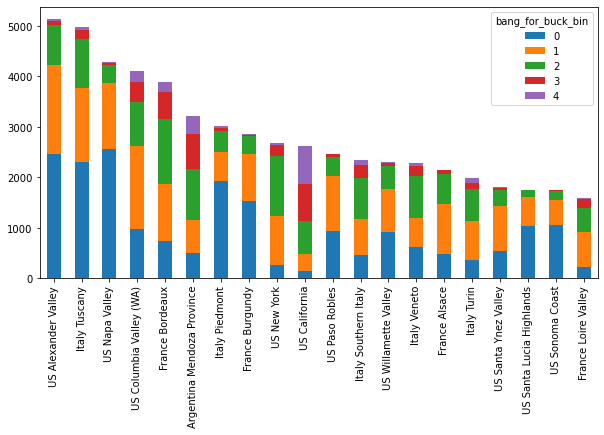

In [201]:
toploc = wine_df['address'].value_counts()[:20]

test = wine_df.groupby(['address', 'bang_for_buck_bin'])['address'].count().unstack('bang_for_buck_bin')
test = test.rename(columns=str).reset_index()

test = test.loc[test['address'].apply(lambda x: x in toploc)]
test = test.set_index('address').reindex(toploc.to_frame().index)

fig, ax = plt.subplots(figsize = (10, 5))
test.plot( kind = 'bar', stacked = True, ax = ax)

# Description and comments

It's time to get involved in the more complicated side of things... the comments! Let's first take a look at the length of comments and if it shows any relationship to the points.

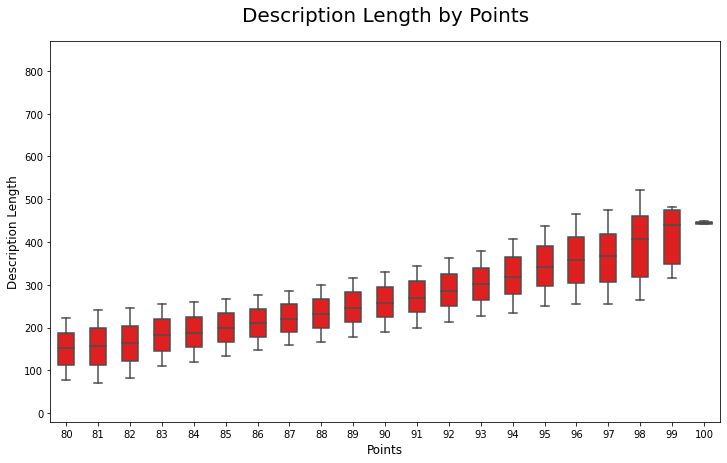

In [273]:
wine_df = wine_df.assign(desc_length = wine_df['description'].apply(len))

plt.figure(figsize=(12,7))
g = sns.boxplot(x='points', y='desc_length', data=wine_df, color='red', width = 0.5, fliersize = 0, whis = 0.5)
g.set_title('Description Length by Points', fontsize=20, pad = 20)
g.set_ylabel('Description Length', fontsize = 12)
g.set_xlabel('Points', fontsize = 12)
plt.show()

Fascinating. It's quite obvious that people have used so many more words to describe the wines that they liked, versus the ones that did not stand out to them.


Next, let's use python's wordcloud library to find the most repeated words in those texts.

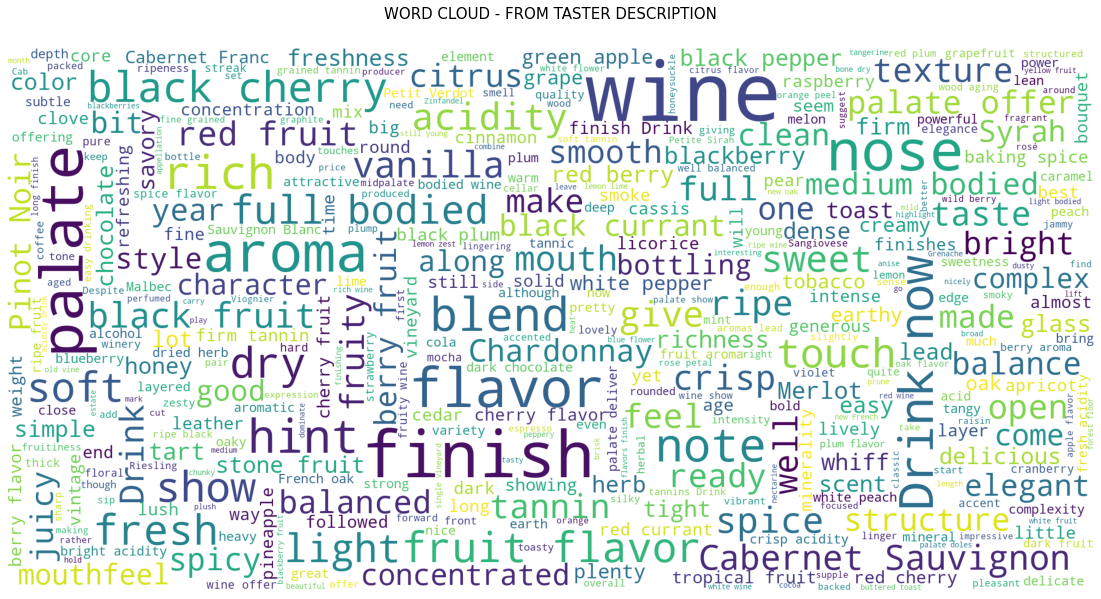

In [112]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=400,
    max_font_size=150, 
    width=2000, 
    height=1000,
    random_state=25,
).generate(" ".join(wine_df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - FROM TASTER DESCRIPTION",fontsize=15, pad = 30)
plt.axis('off')
plt.show()

Now we can use the image above to fine tune the Stopwords. I will be adding anything and everything that does not do much to describe the wine quality, from big and ready to common english words that don't really provide much value here.

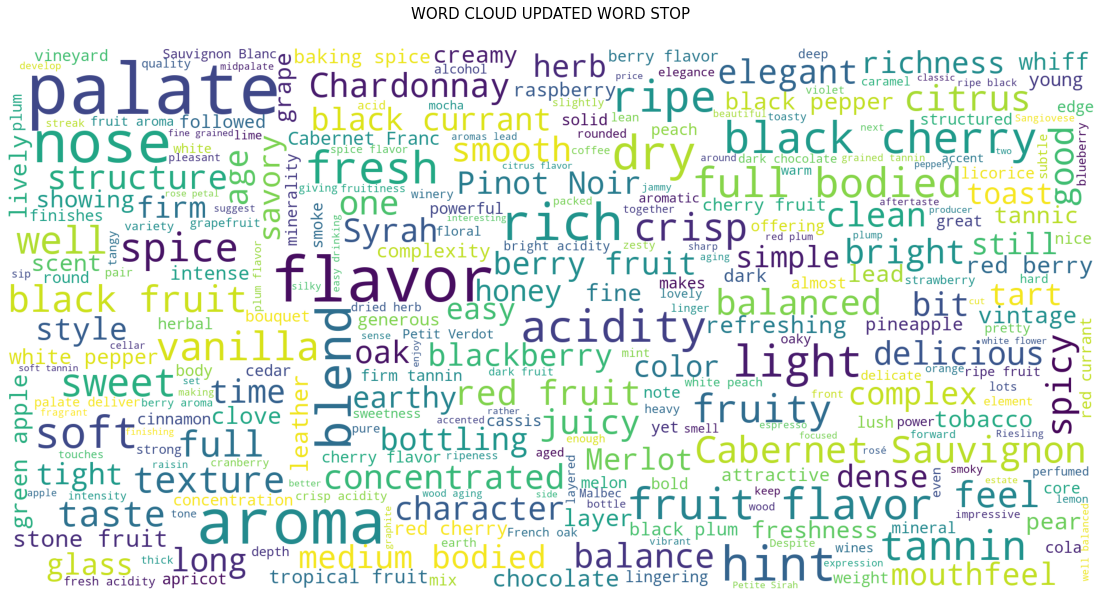

In [113]:
newStopWords = ['wine', 'Drink', 'now', 'show', 'along', 'close', 'come', 'plenty', 
                'ready', 'make', 'big', 'will', 'seem', 'much', 'open', 'offer', 'add',
                'finish', 'offers', 'shows', 'little', 'way', 'need', 'start', 'year', 
                'right', 'best', 'first', 'needs', 'lot', 'take', 'bring', 'comes', 
                'quite', 'years', 'give', 'touch', 'made', 'end', 'opens', 'mouth',
                'brings', 'overall', 'notes', 'although', 'gives', 'find', 'though',
                'seems', 'produced', 'aren', 'couldn', 'didn', 'doesn', 'don', 'drink',
                'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 
                'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'drink', '2017', '2018']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=130, 
    width=2000, 
    height=1000,
    random_state=25,
).generate(" ".join(wine_df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD UPDATED WORD STOP",fontsize=15, pad = 30)
plt.axis('off')
plt.show()

Much better. Everyword that I see in this image is a meaningful word to describe a quality in a wine, it's ingredients, the aroma, or the texture of it.

PRINCIPAL WORDS CATEGORY: Pinot Noir
PRINCIPAL WORDS CATEGORY: Chardonnay
PRINCIPAL WORDS CATEGORY: Cabernet Sauvignon
PRINCIPAL WORDS CATEGORY: Red Blend
PRINCIPAL WORDS CATEGORY: Bordeaux-style Red Blend
PRINCIPAL WORDS CATEGORY: Riesling
PRINCIPAL WORDS CATEGORY: Sauvignon Blanc
PRINCIPAL WORDS CATEGORY: Syrah
PRINCIPAL WORDS CATEGORY: Rosé
PRINCIPAL WORDS CATEGORY: Merlot


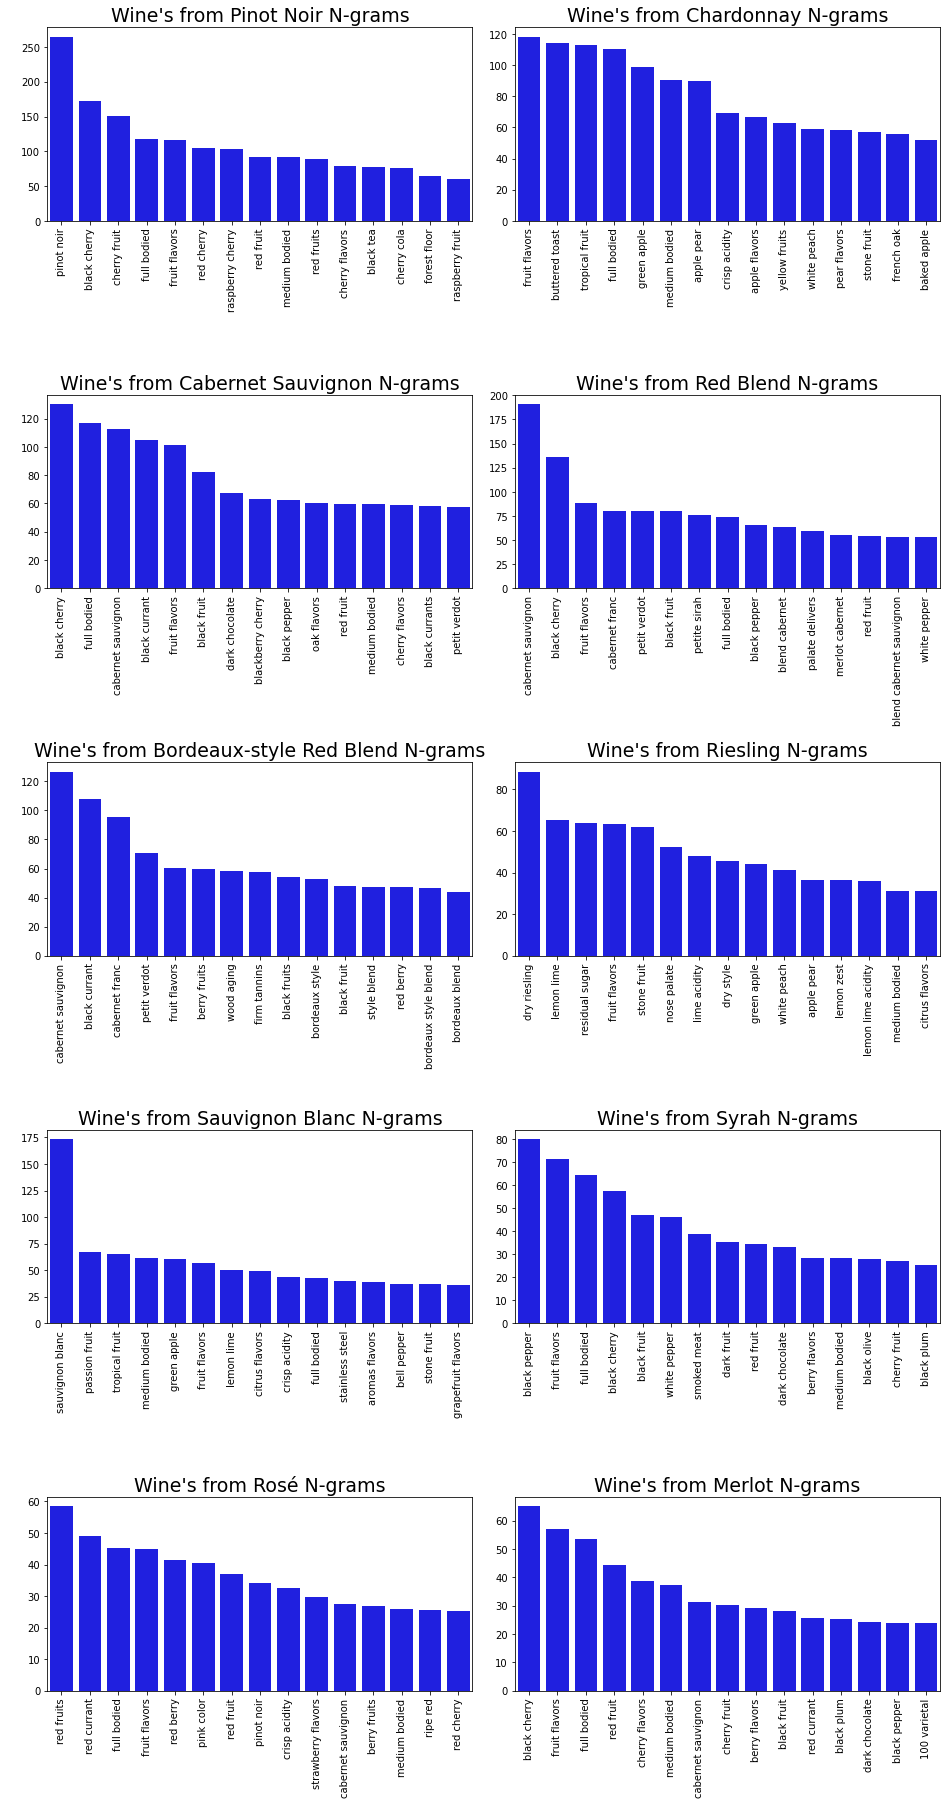

In [274]:
# credit to https://www.kaggle.com/kabure, work in progress.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.gridspec as gridspec # to do the grid of plots

grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(16,7*4))

var = wine_df['variety'].value_counts()[:30]

for n, cat in enumerate(var.index[:10]):
    ax = plt.subplot(grid[n])   
    print(f'PRINCIPAL WORDS CATEGORY: {cat}')
    vectorizer = CountVectorizer(ngram_range = (3,3)) 
    vectorizer = TfidfVectorizer(ngram_range = (2, 3), min_df=5, stop_words= stopwords, max_df=.5) 
    
    X2 = vectorizer.fit_transform(wine_df.loc[(wine_df['variety'] == cat)]['description']) 
    #print(wine_df.iloc[(wine_df['address'])], cat)
    features = (vectorizer.get_feature_names()) 
    scores = (X2.toarray())
    
    sums = X2.sum(axis = 0) 
    data1 = [] 
    
    for col, term in enumerate(features): 
        data1.append( (term, sums[0,col] )) 

    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False))[:15]
    
    sns.barplot(x='term', y='rank', data=words, ax=ax, 
                color='blue', orient='v')
    ax.set_title(f"{cat} N-grams", fontsize=19)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel(' ')
    ax.set_xlabel(" ")

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.1)

plt.show()

My next step here would be to mark up a data frame with the words we found in the wordcloud, do some investigation and compare the ways to group the wines by, extract numbers representing those words for each category (by country? by winery? by variety?), then do a K-means on that data frame to find ways to cluster these wines together. 